# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных:
Признаки:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:

- `Price` — цена (евро)

In [1]:
!pip install category_encoders

     |████████████████████████████████| 81 kB 1.1 MB/s eta 0:00:011


## Подготовка данных

In [13]:
# Импорт библиотеки pandas для работы с данными
import pandas as pd
# Импорт библиотеки numpy для работы с массивами и матрицами
import numpy as np
# Импорт модуля re для работы с регулярными выражениями
import re
# Импорт модуля datetime для работы с датами и временем
import datetime

# Импорт модуля plotly.express для визуализации данных
import plotly.express as px
# Импорт модуля plotly.graph_objects для создания графиков
import plotly.graph_objects as go
# Импорт модуля matplotlib.pyplot для создания графиков
import matplotlib.pyplot as plt
# Импорт модуля seaborn для визуализации данных
import seaborn as sns                           

# Импорт библиотек для обучения моделей
# Импорт функции train_test_split для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
# Импорт функции shuffle для перемешивания данных
from sklearn.utils import shuffle
# Импорт класса GridSearchCV для подбора гиперпараметров модели
from sklearn.model_selection import GridSearchCV
# Импорт функции cross_val_score для кросс-валидации
from sklearn.model_selection import cross_val_score               

# Импорт класса LinearRegression для линейной регрессии
from sklearn.linear_model import LinearRegression
# Импорт класса DecisionTreeRegressor для решающих деревьев
from sklearn.tree import DecisionTreeRegressor
# Импорт класса RandomForestRegressor для случайного леса
from sklearn.ensemble import RandomForestRegressor
# Импорт класса DummyRegressor для базовой модели
from sklearn.dummy import DummyRegressor 
# Импорт библиотеки TransformedTargetRegressor для преобразования целевой переменной
from sklearn.compose import TransformedTargetRegressor

import category_encoders as ce

# Импорт классов CatBoostClassifier и CatBoostRegressor для работы с CatBoost
from catboost import Pool, CatBoostClassifier, CatBoostRegressor  

# Импорт библиотеки lightgbm для работы с LightGBM
import lightgbm as lgb                                           

# Импорт метрик
# Импорт функции make_scorer для создания своей метрики
from sklearn.metrics import make_scorer
# Импорт функции mean_squared_error для вычисления среднеквадратичной ошибки
from sklearn.metrics import mean_squared_error                    

# Импорт библиотек для создания пайплайнов
# Импорт класса Pipeline для создания пайплайнов
from sklearn.pipeline import Pipeline
# Импорт класса ColumnTransformer для преобразования колонок
from sklearn.compose import ColumnTransformer
# Импорт различных преобразователей для предобработки данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder

# Импорт библиотеки для работы с категориальными данными
import category_encoders as ce

# Импорт класса ColumnTransformer для преобразования колонок
from sklearn.compose import ColumnTransformer

# Импорт различных преобразователей для предобработки данных
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Импорт класса RandomForestRegressor для построения модели случайного леса
from sklearn.ensemble import RandomForestRegressor
                                                                
# Импорт модуля warnings для управления предупреждениями
import warnings
# Отключение вывода предупреждений
warnings.filterwarnings('ignore')

In [3]:
# Присваиваем переменной random_state значение 123456789
random_state = 123456789

In [5]:
# Выводим информацию о версиях установленных библиотек
!pip show pandas seaborn numpy matplotlib plotly category_encoders catboost lightgbm

Name: pandas
Version: 1.2.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: python-dateutil, pytz, numpy
Required-by: statsmodels, seaborn, category-encoders, catboost
---
Name: seaborn
Version: 0.11.1
Summary: seaborn: statistical data visualization
Home-page: https://seaborn.pydata.org
Author: Michael Waskom
Author-email: mwaskom@nyu.edu
License: BSD (3-clause)
Location: /opt/conda/lib/python3.9/site-packages
Requires: pandas, numpy, matplotlib, scipy
Required-by: 
---
Name: numpy
Version: 1.21.1
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: 
Required-by: xgboost, transformers, thinc, tensorflow-cpu, tensorboard, statsmodels, spa

### Загрузка данных

Загрузим данные таблицы и проверим общую информацию об атрибутах таблицы.

In [12]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/autos.csv'
try:
    data_auto = pd.read_csv('/datasets/autos.csv', sep=',')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/autos.csv'
    data_auto = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep=',')

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'data_auto'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.
data_auto

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [9]:
# Вывод общей информации о DataFrame
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
# Получение количества строк в DataFrame
auto_count = data_auto.shape[0]
auto_count

354369

In [11]:
# Используем метод isnull() для определения пропущенных значений в DataFrame data_auto
# Затем применяем метод sum() для подсчета суммы пропущенных значений по каждому столбцу
missing_values = data_auto.isnull().sum()
missing_values

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [12]:
# Используем метод isna() для определения пропущенных значений в DataFrame data_auto
# Затем применяем метод mean() для вычисления доли пропущенных значений по каждому столбцу
missing_percentages = round(data_auto.isna().mean() * 100,2)
missing_percentages

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
Repaired             20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

In [13]:
# Вывод статистического описания DataFrame
data_auto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


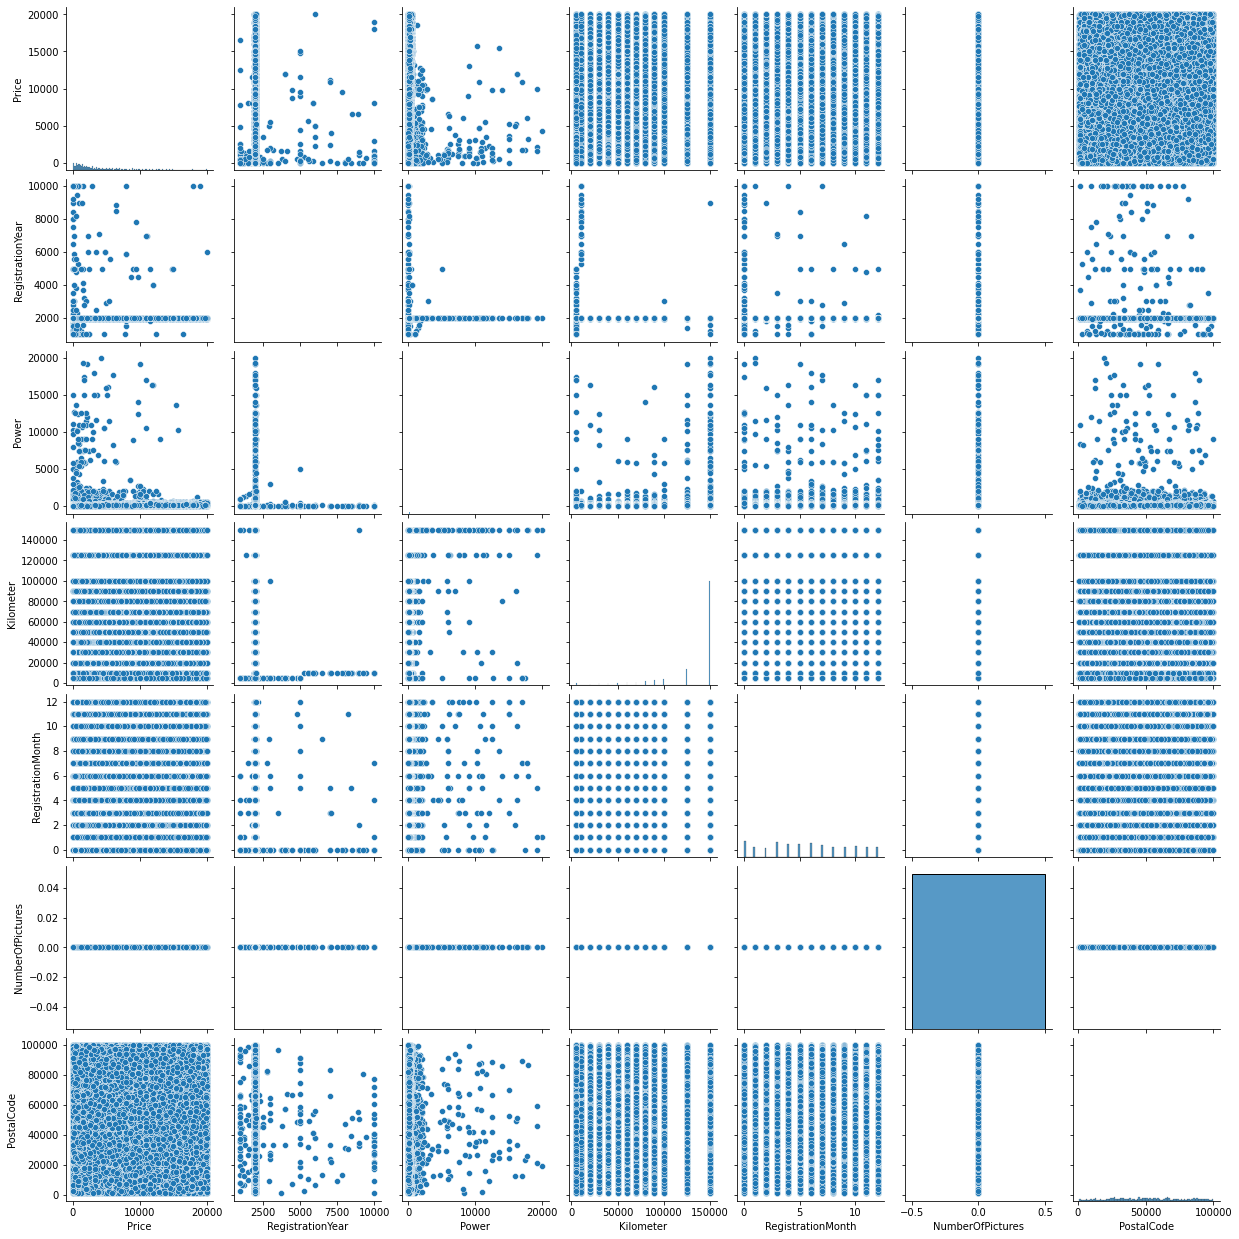

In [14]:
# Использование функции pairplot для создания матрицы графиков рассеяния
# Функция автоматически строит графики для всех пар признаков в DataFrame data_auto
sns.pairplot(data_auto);

# Вывод

В таблице содержится примерно 355 тысяч записей об объявлениях о продаже автомобилей. Целевым признаком является цена автомобиля (Price), указанная в евро.

Структура атрибутов соответствует ожидаемой. Для удобства работы рекомендуется привести названия атрибутов из формата CamelCase в формат snake_case.

В таблице присутствуют 9 строковых и 7 целочисленных атрибутов. Имеются пропуски значений в следующих атрибутах:
- VehicleType — тип автомобильного кузова
- Gearbox — тип коробки передач
- Model — модель автомобиля
- FuelType — тип топлива
- NotRepaired — была машина в ремонте или нет

Также обнаружены аномальные значения в некоторых атрибутах:
- '9999' - год регистрации
- 0 - месяц регистрации
- 0 - цена автомобиля
- 20000 - мощность (л. с.)

Решение о способе обработки пропусков и замене аномальных значений следует принять на этапе предобработки данных.

Персональная информация пользователей, такая как почтовый код и время последней активности, не является релевантной и может быть исключена из рассмотрения.

Также в данных содержатся признаки, связанные с объявлениями, а не с характеристиками автомобилей, такие как количество фотографий, дата создания и выгрузки объявления. Признак количества фотографий имеет только одно значение - 0, и его можно исключить из анализа.

## Предобработка данных

Проведем преобразование названий признаков из 'CamelCase' в 'snake_case'.

In [15]:
# Используем функцию rename() для переименования столбцов
# Функция lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x) применяется к каждому названию столбца x
# В данном случае, функция выполняет замену названия из CamelCase в snake_case
# re.sub('(?!^)([A-Z]+)', r'_\1', x) разделяет названия по заглавным буквам и добавляет перед ними знак подчеркивания
# .lower() преобразует все символы в нижний регистр
# inplace=True обновляет исходный DataFrame без создания копии

data_auto.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x).lower(), inplace=True)

In [16]:
# Вывод первых 5 строк данных
data_auto.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [17]:
# Вывод общей информации о DataFrame
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Проверим на дубликаты, вызвав метод .duplicated()

In [18]:
# Подсчет дубликатов
data_auto.duplicated().sum()

4

In [19]:
# Поиск дубликатов
data_auto[data_auto.duplicated() == True]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [20]:
# Удаление дублирующихся строк из DataFrame
data_auto.drop_duplicates(inplace=True)

 **Удаление лишних колонок**

Столбцы `'DateCrawled'` и `'LastSeen'` содержат информацию о датах и времени, когда анкета была скачана из базы и последний раз просмотрена соответственно. В данном контексте эти временные метки могут иметь незначительное влияние на цену автомобиля.

Столбец `'DateCreated'` указывает на дату создания анкеты, что может быть важным для анализа актуальности информации, но возможно не существенно для прогнозирования цены.

Столбец `'NumberOfPictures'` указывает на количество фотографий автомобиля, которое, хотя и может быть полезным для визуального представления автомобиля, возможно не сильно влияет на его рыночную стоимость.

Столбец `'PostalCode'` содержит почтовый индекс владельца анкеты, что, скорее всего, не является релевантным фактором для определения цены автомобиля.

Исходя из вышесказанного удалим столбцы `'DateCrawled'`, `'DateCreated'`, `'NumberOfPictures'`, `'PostalCode'` и `'LastSeen'`.

In [21]:
# Используем метод drop() для удаления столбцов 'number_of_pictures', 'postal_code' и 'last_seen'
# Параметр columns принимает список названий столбцов, которые нужно удалить
# Параметр inplace=True указывает, что изменения должны быть внесены непосредственно в DataFrame
data_auto.drop(columns=['date_crawled','date_created', 'number_of_pictures', 'postal_code', 'last_seen'], inplace=True)

In [22]:
# Вывод первых 5 строк данных
data_auto.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Первая предобработка данных выполнена, и избыточные признаки были исключены. Теперь перейдем к оценке значений представленных признаков для выявления аномалий и обработке пропущенных данных.

**Оценка распределения значений признаков, выявление пропусков и аномалий**

Начнем с анализа признаков, содержащих временные характеристики, затем перейдем к рассмотрению марки автомобиля, так как это один из основных признаков, который неявно определяет другие признаки. После этого рассмотрим числовые и категориальные признаки.

In [23]:
# функция отображения сводной информации о числовом признаке:
# выводит в текстовом виде основные параметры распределения значений признака и график (гистограмму и "ящик с усами")
# распределения по категориям:
# действующие и ушедшие клиенты

def desc_col_numeric(column, df, to_plot=True):
    # Шаг 1: Вывод названия признака
    print('Признак', column, ':')

    # Шаг 2: Вывод описательной статистики
    print(df[column].describe())

    if to_plot:
        # Шаг 3: Создание графиков
        fig, ax = plt.subplots(2, 1, figsize=(19, 12))

        # Гистограмма с кривой плотности
        sns.histplot(data=df, x=column, ax=ax[0], kde=True)
        ax[0].set_title('Распределение значений признака {}'.format(column))
        ax[0].grid(True)

        # Ящик с усами (горизонтальный)
        sns.boxplot(data=df, x=column, ax=ax[1], orient='h')
        ax[1].set_title('Ящик с усами признака {}'.format(column))
        ax[1].grid(True)

        # Шаг 4: Добавление серого прозрачного фона
        ax[1].axvspan(df[column].min(), df[column].max(), facecolor='gray', alpha=0.1)

        # Шаг 5: Отображение графиков
        plt.tight_layout()
        plt.show()

In [24]:
# функция отображения сводной информации о категориальном признаке:
# выводит в текстовом виде униклаьные значения признака и график (гистограмму) распределения по категориям:
# действующие и ушедшие клиенты

def desc_col_category(column, df, to_plot=True):
    # Шаг 1: Вывод названия признака
    print('Признак', column, ':\n')

    # Шаг 2: Вывод уникальных значений с процентным соотношением
    print('Уникальные значения (процент):')
    print(df[column].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

    if to_plot:
        # Шаг 3: Создание графика
        fig, ax = plt.subplots(figsize=(19, 12))

        # Гистограмма
        sns.countplot(data=df, x=column, ax=ax)
        ax.set_title('Распределение значений признака {}'.format(column))
        ax.grid(True)

        # Шаг 4: Отображение графика
        plt.tight_layout()
        plt.show()

**Год регистрации автомобиля (`registration_year`)**

Подробнее посмотрим распределение значений признака года регистрации.

In [25]:
# Вывод описательной статистики признака 'registration_year'
data_auto['registration_year'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Пропусков нет, но есть аномальные значения - 1000 и 9999. Рассмотрим их подробнее.

Признак registration_year :
count    3452.000000
mean     1953.011587
std       114.420128
min      1000.000000
25%      1965.000000
50%      1971.000000
75%      1976.000000
max      1979.000000
Name: registration_year, dtype: float64


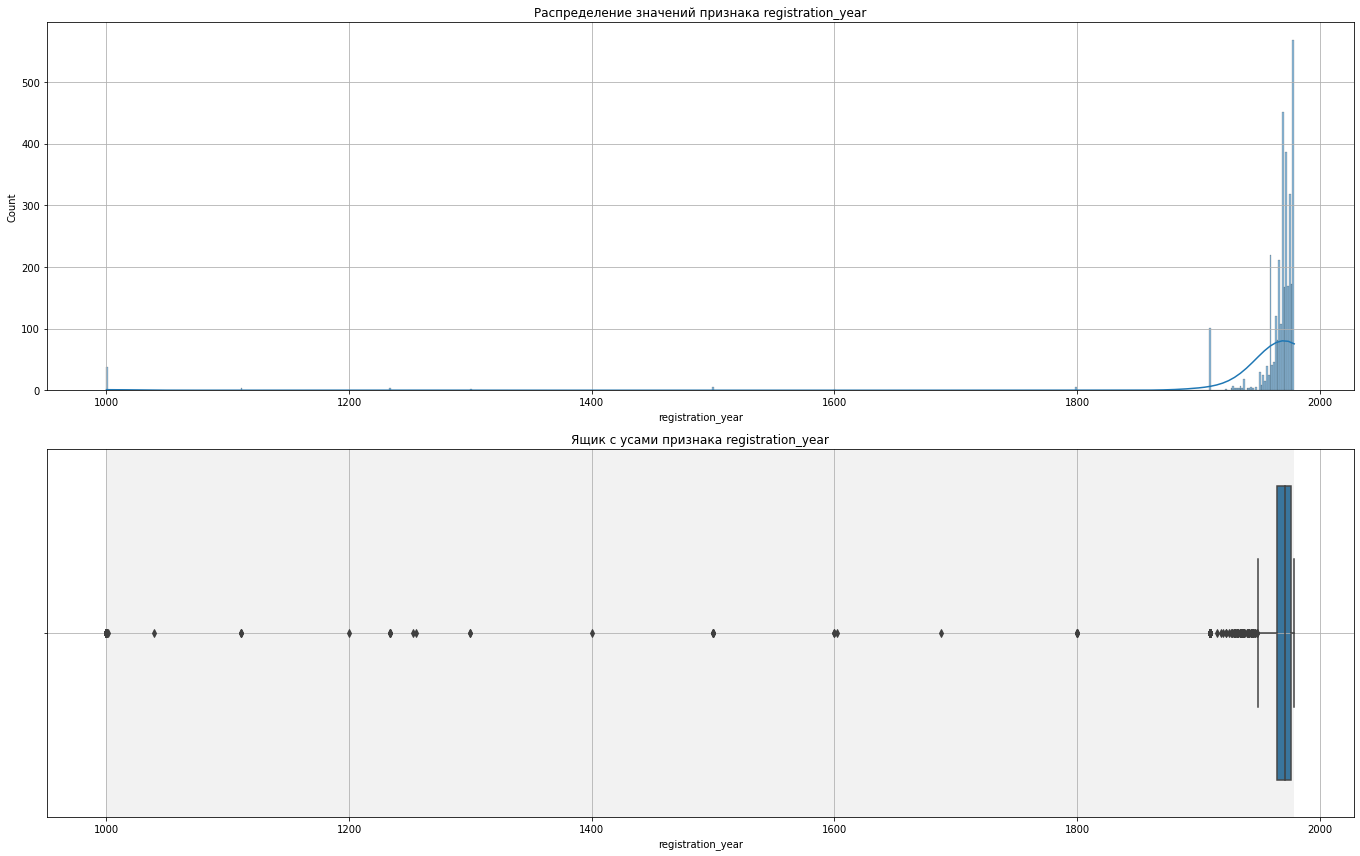

In [26]:
# Вызов функции для оценки признака 'registration_year' с условием значения меньше 1980
desc_col_numeric('registration_year', data_auto.query('registration_year < 1980'))

Признак registration_year :
count     130.000000
mean     5556.915385
std      3017.188969
min      2019.000000
25%      2500.000000
50%      5000.000000
75%      8791.000000
max      9999.000000
Name: registration_year, dtype: float64


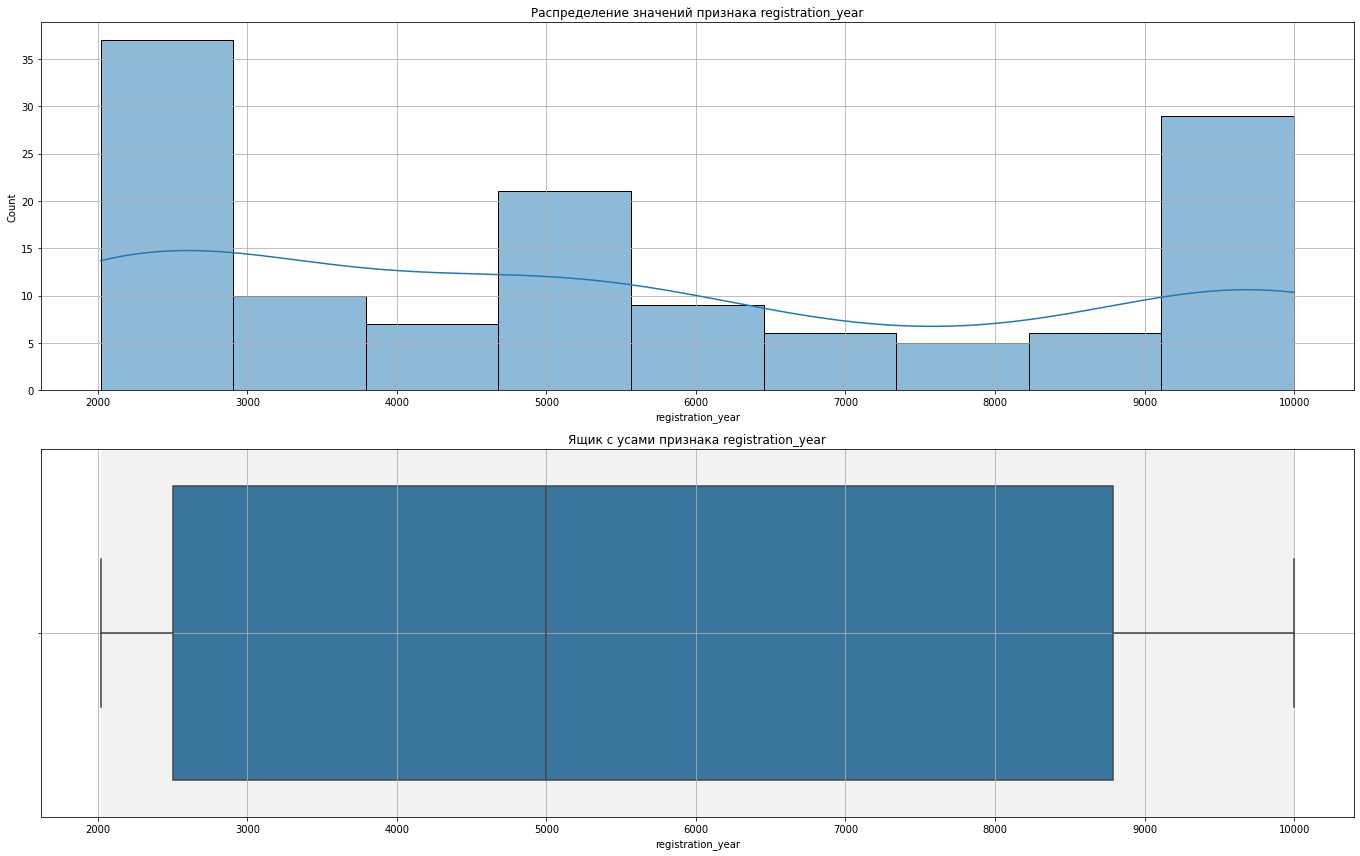

In [27]:
# Вызов функции для оценки признака 'registration_year' с условием значения больше 2018
desc_col_numeric('registration_year', data_auto.query('registration_year > 2018'))

In [28]:
# Шаг 1: Вычисление доли объявлений с указанием года регистрации до 1960
ratio_before_1960 = data_auto.query('registration_year < 1960')['registration_year'].count() / data_auto.shape[0]

# Шаг 2: Вывод доли объявлений с указанием года регистрации до 1960
print('Доля объявлений с указанием года регистрации до 1960: {0:.2%}'.format(ratio_before_1960))

# Шаг 3: Вычисление доли объявлений с указанием года регистрации после 2016
ratio_after_2016 = data_auto.query('registration_year > 2016')['registration_year'].count() / data_auto.shape[0]

# Шаг 4: Вывод доли объявлений с указанием года регистрации после 2016
print('Доля объявлений с указанием года регистрации после 2016: {0:.2%}'.format(ratio_after_2016))

# Шаг 5: Вычисление доли объявлений с указанием года регистрации 2017, 2018 или 2019
ratio_2017_2019 = data_auto.query('registration_year in (2017, 2018, 2019)')['registration_year'].count() / data_auto.shape[0]

# Шаг 6: Вывод доли объявлений с указанием года регистрации 2017, 2018 или 2019
print('Доля объявлений с указанием года регистрации 2017, 2018 или 2019: {0:.2%}'.format(ratio_2017_2019))

Доля объявлений с указанием года регистрации до 1960: 0.12%
Доля объявлений с указанием года регистрации после 2016: 4.10%
Доля объявлений с указанием года регистрации 2017, 2018 или 2019: 4.07%


Подробнее рассмотрим объявления с аномальными значениями года регистрации.

In [29]:
# Вывод первых 20 строк из отфильтрованного DataFrame
data_auto.query('registration_year < 1960').head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN
622,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN
1928,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no
2273,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no
3333,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,NaN
6629,0,small,1910,NaN,0,NaN,5000,1,other,sonstige_autos,NaN
6977,135,NaN,1910,NaN,0,NaN,5000,0,NaN,opel,NaN
10183,1250,NaN,1910,NaN,0,other,5000,0,NaN,audi,NaN
12992,0,small,1954,manual,54,corsa,150000,0,petrol,opel,no
12993,11000,other,1955,manual,40,NaN,50000,1,petrol,sonstige_autos,no


В исходных данных обнаружены объявления, которые содержат большое количество пропусков или аномалий в различных признаках. Например, некоторые объявления не содержат информации о типе кузова, типе коробки передач, мощности, модели или типе топлива, что делает их менее полезными для обучения модели.

Кроме того, обнаружены некоторые потенциально аномальные значения в других атрибутах, которые требуют дополнительной оценки и рассмотрения. Некоторые из таких значений включают:

- Значение марки автомобиля `"sonstige_autos"` (переводится с немецкого как "прочие автомобили"), которое, вероятно, является обобщенной категорией и может быть неинформативным для модели.
- Совпадение года регистрации и мощности, а также значения мощности, превышающие 1000. Это может быть результатом ошибки, где указан объем двигателя вместо мощности.
- Пробег, равный 5000, который, скорее всего, представляет собой значение по умолчанию или ошибочно введенные данные.
- Значения цены, равные 0 и 1, а также другие значения в пределах 100 евро. Эти значения могут быть неточными или ошибочными.
- Значение 0 в месяце регистрации, что является неправдоподобным значением для этого признака.

Такие объявления, содержащие аномалии в нескольких атрибутах, составляют всего около 0.06% от общего объема выборки данных. В связи с этим, рекомендуется исключить эти объявления из дальнейшего анализа и рассмотрения данных, чтобы обеспечить более надежную и точную модель.

In [30]:
# Фильтрация DataFrame для включения только строк, где registration_year больше или равен 1980 году
data_auto = data_auto.query('registration_year >= 1980')

In [31]:
# Выбор строк с условием значения 'registration_year' больше 2023
data_auto.query('registration_year > 2023').head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
12946,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN
15147,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN
15870,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN
17271,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN
17346,6500,NaN,8888,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN
18259,300,NaN,2200,NaN,0,twingo,5000,12,NaN,renault,NaN
20159,1600,NaN,4100,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN
26382,150,NaN,3000,NaN,0,a_klasse,5000,0,NaN,mercedes_benz,NaN
26560,800,NaN,2066,NaN,0,zafira,5000,0,gasoline,opel,NaN
28390,799,NaN,9999,NaN,0,3er,10000,4,petrol,bmw,NaN


Также обращаем внимание на наличие записей с большим количеством пропусков/аномалий. К новым возможно аномальным значениям также следует отнести:
- значения цены, составленные из одной цифры (11111, 5555)

Удаляем все объявления с указанием года после 2023 в качестве года регистрации.

In [32]:
# Фильтрация DataFrame для включения только строк, где registration_year меньше или равен 2023 году
data_auto = data_auto.query('registration_year <= 2016')

Признак registration_year :
count    336383.000000
mean       2002.828912
std           6.082015
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64


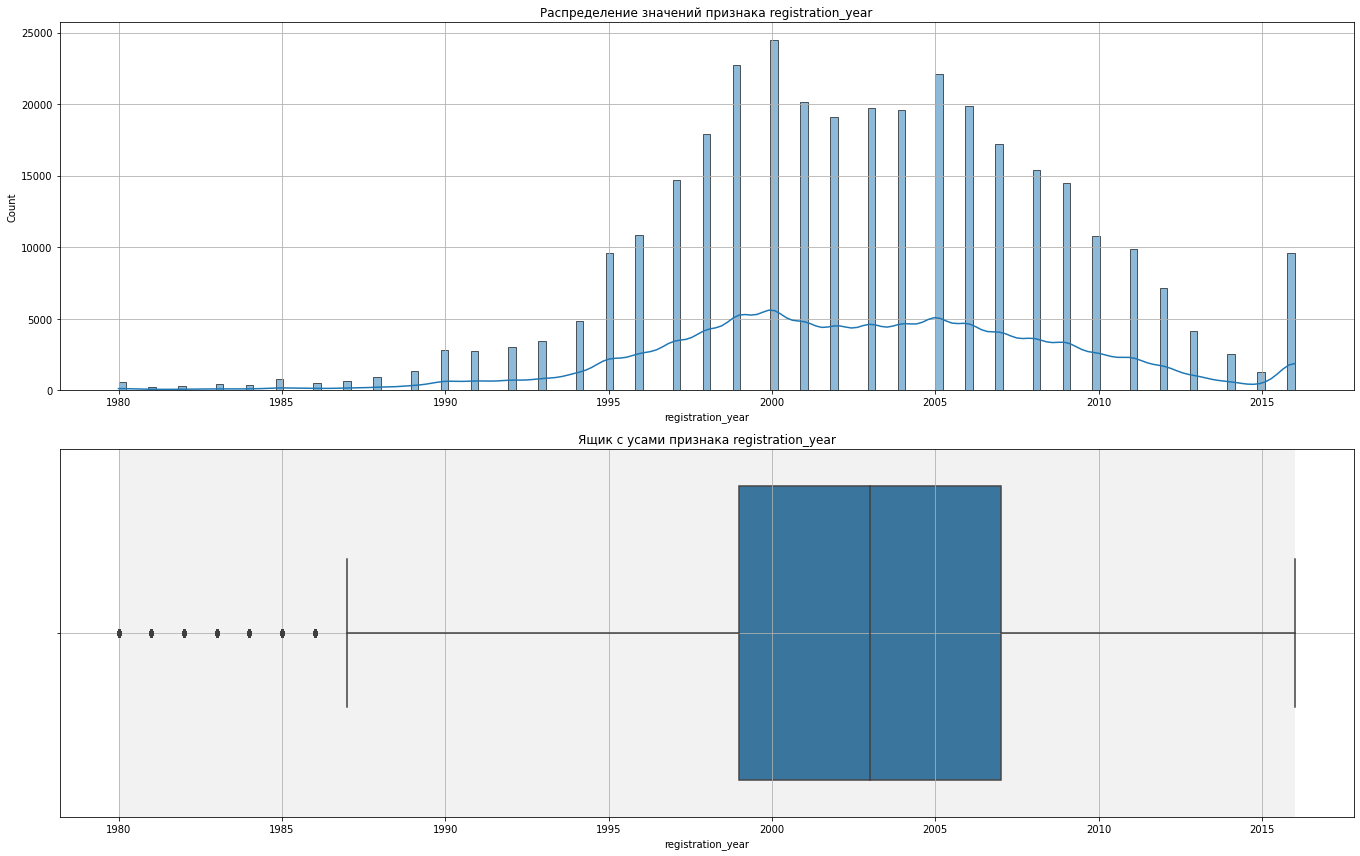

In [33]:
# Вызов функции для признака 'registration_year' в DataFrame 'data_auto'
desc_col_numeric('registration_year', data_auto)

Оставим данные в диапазоне (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

In [34]:
# Шаг 1: Расчет первого и третьего квартилей
Q1 = data_auto['registration_year'].quantile(0.25)
Q3 = data_auto['registration_year'].quantile(0.75)

# Шаг 2: Расчет межквартильного размаха (IQR)
IQR = Q3 - Q1

# Шаг 3: Определение нижней и верхней границ выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Шаг 4: Вывод диапазона выбросов
print("Диапазон выбросов: ({}, {})".format(lower_bound, upper_bound))

Диапазон выбросов: (1987.0, 2019.0)


In [35]:
# ильтрация DataFrame по условию регистрации автомобиля после 1985 года
data_auto = data_auto.query('registration_year >= 1985')

Кроме того, удалим данные имеющие большое количество пропусков/аномалий.

In [36]:
# Шаг 1: Создание условия для фильтрации
condition = 'vehicle_type.isnull() and gearbox.isnull() and power == 0 \
             and fuel_type.isnull() and brand==\'sonstige_autos\' and repaired.isnull()'

# Шаг 2: Выполнение запроса и получение индексов строк, которые соответствуют условию
rows_to_drop = data_auto.query(condition, engine='python').index

# Шаг 3: Удаление строк с помощью метода drop() и параметра inplace=True
data_auto.drop(rows_to_drop, inplace=True)

In [37]:
# Вывод информации о DataFrame до выполнения кода
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333875 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               333875 non-null  int64 
 1   vehicle_type        312175 non-null  object
 2   registration_year   333875 non-null  int64 
 3   gearbox             317545 non-null  object
 4   power               333875 non-null  int64 
 5   model               317929 non-null  object
 6   kilometer           333875 non-null  int64 
 7   registration_month  333875 non-null  int64 
 8   fuel_type           308240 non-null  object
 9   brand               333875 non-null  object
 10  repaired            271368 non-null  object
dtypes: int64(5), object(6)
memory usage: 30.6+ MB


**Месяц регистрации  (`registration_month`)**

Далее проведем более детальный анализ данных, чтобы рассмотреть случаи, где месяц регистрации равен 0.

In [38]:
# Выполнение запроса для выбора строк, где месяц регистрации равен 0
data_auto.query('registration_month == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no
...,...,...,...,...,...,...,...,...,...,...,...
354305,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN
354318,400,wagon,1991,manual,0,legacy,150000,0,petrol,subaru,NaN
354326,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN
354329,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN


Признак registration_month :
count    333875.000000
mean          5.786890
std           3.702562
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


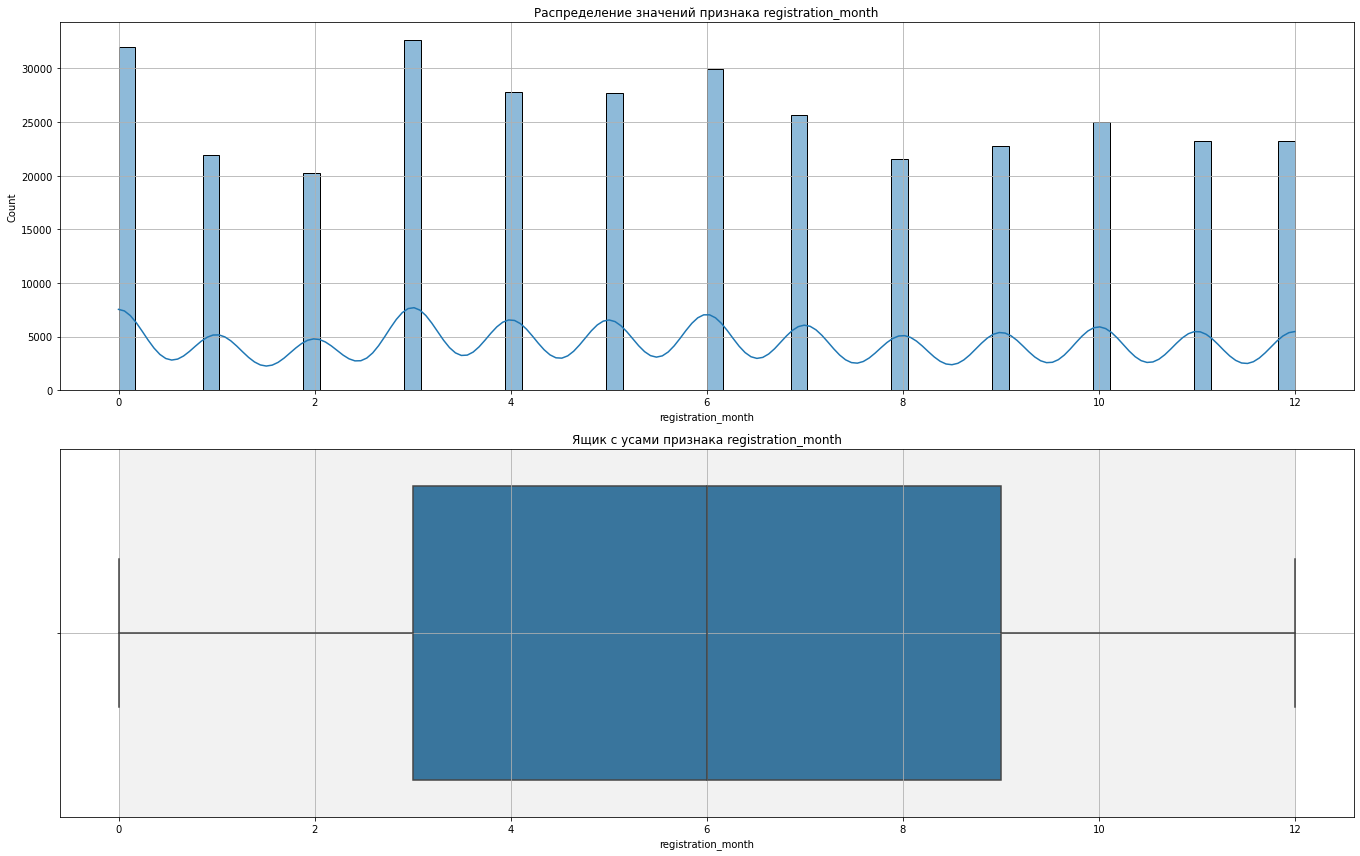

In [39]:
# Вызов функции для описания числового столбца 'registration_month'
desc_col_numeric('registration_month', data_auto)

In [40]:
# Вывод уникальных значений с процентным соотношением
print('Уникальные значения (процент):')
print(data_auto['registration_month'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Уникальные значения (процент):
3     9.8%
0     9.6%
6     9.0%
4     8.3%
5     8.3%
7     7.7%
10    7.5%
12    7.0%
11    7.0%
9     6.8%
1     6.6%
8     6.5%
2     6.1%
Name: registration_month, dtype: object


Около 10% от общего числа объявлений содержат значение 0 в качестве месяца регистрации. Так как данные по месяцу регистрации равномерно распределены, для замены значения 0 целесообразно сохранить исходное распределение. Предлагается произвести замену случайным образом, используя числа из диапазона от 1 до 12. Для этого применим модуль 12 к индексам записей и добавим 1. Таким образом, значение месяца регистрации будет заменено на случайное число от 1 до 12, сохранив при этом статистические характеристики и равномерность распределения.

In [41]:
# Выбираем строки, где месяц регистрации равен 0
selected_rows = data_auto.query('registration_month == 0')

# Применяем модуль 12 и добавляем 1 к индексам выбранных строк
replacement_values = selected_rows.index % 12 + 1

# Заменяем значения месяца регистрации на полученные случайные значения
data_auto.loc[data_auto['registration_month'] == 0, 'registration_month'] = replacement_values

Признак registration_month :
count    333875.000000
mean          6.408878
std           3.361037
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


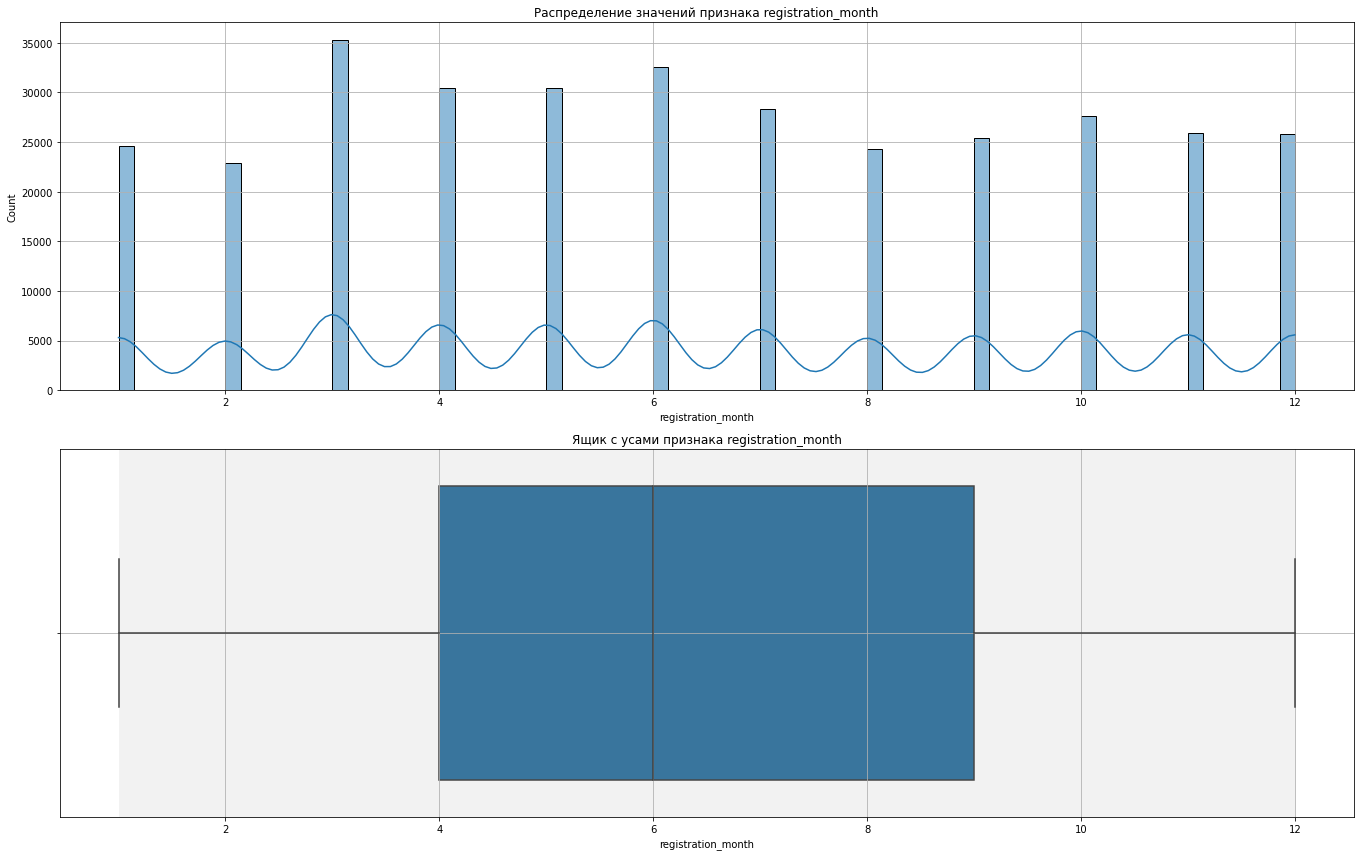

In [42]:
# Описательная статистика и графики для признака 'registration_month'
desc_col_numeric('registration_month', data_auto)

Характер распределения не изменился, аномаьное значение '0' устранено.

**Марка автомобиля (`brand`)**

Давайте проанализируем распределение значений в признаке `"марка автомобиля"`. Как уже было отмечено, значение `"sonstige_autos"` относится к категории "прочие марки автомобилей" и является аномальным. Марка автомобиля является важным признаком, так как определяет модель и, косвенно, влияет на многие другие характеристики (например, тип кузова или мощность), которые могут быть связаны с определенными марками автомобилей. Чтобы получить представление о доле автомобилей без указания марки в общем объеме данных, выполним соответствующую оценку.

In [43]:
# Фильтрация данных по условию: марка автомобиля равна 'sonstige_autos'
data_auto.query('brand == \'sonstige_autos\'')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN
431,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no
661,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no
700,6999,sedan,2010,auto,186,NaN,125000,4,petrol,sonstige_autos,no
985,500,sedan,2010,manual,101,NaN,70000,1,petrol,sonstige_autos,yes
...,...,...,...,...,...,...,...,...,...,...,...
353756,250,small,1997,manual,66,NaN,150000,5,petrol,sonstige_autos,NaN
353867,5000,sedan,2006,manual,175,NaN,125000,12,petrol,sonstige_autos,no
353892,7900,bus,2009,NaN,140,NaN,125000,7,gasoline,sonstige_autos,no
354062,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no


Признак brand :

Уникальные значения (процент):
volkswagen        21.6%
opel              11.2%
bmw               10.6%
mercedes_benz      9.0%
audi               8.5%
ford               7.1%
renault            5.1%
peugeot            3.2%
fiat               2.7%
seat               2.0%
mazda              1.6%
skoda              1.6%
smart              1.5%
citroen            1.4%
nissan             1.4%
toyota             1.3%
hyundai            1.0%
mini               0.9%
volvo              0.9%
mitsubishi         0.9%
honda              0.8%
kia                0.7%
suzuki             0.7%
alfa_romeo         0.6%
sonstige_autos     0.6%
chevrolet          0.5%
chrysler           0.4%
dacia              0.3%
daihatsu           0.2%
subaru             0.2%
porsche            0.2%
jeep               0.2%
daewoo             0.2%
saab               0.2%
land_rover         0.2%
jaguar             0.1%
rover              0.1%
lancia             0.1%
trabant            0.1%
lada            

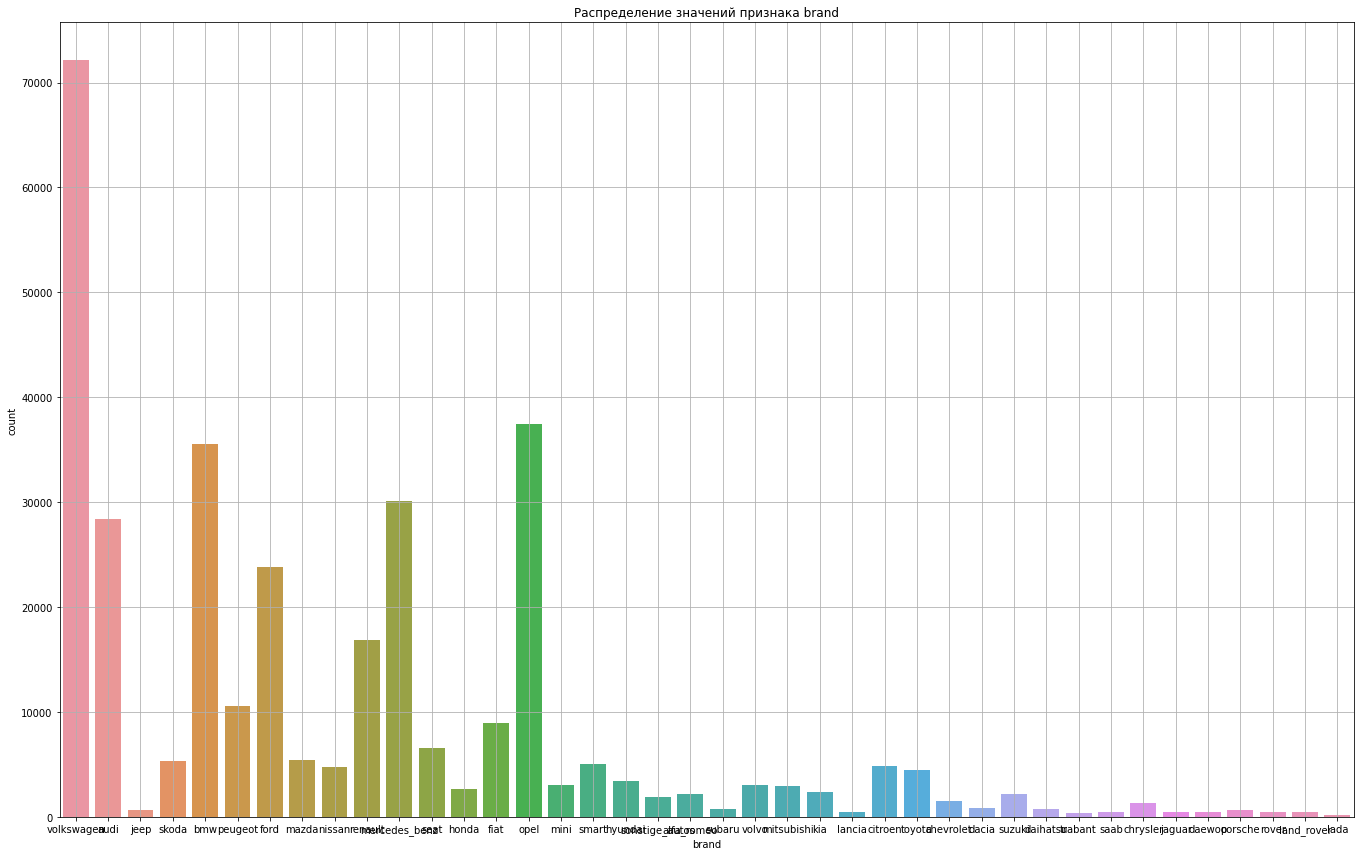

In [44]:
# Вызываем функцию для анализа столбца 'brand' в датафрейме data_auto
desc_col_category('brand', data_auto)

Среди представленных объявлений более `60%` принадлежат немецким автопроизводителям. Это говорит о том, что данные получены с ресурса, ориентированного на немецкий автомобильный рынок. Также, значение `"sonstige_autos"` подтверждает, что присутствуют автомобили других марок.

По независимым оценкам, доля автомобильного рынка занимается определенными марками, такими как `Volkswagen`, `Opel`, `BMW`, `Mercedes`, `Audi`, `Ford`, `Renault`, `Peugeot`, `Fiat` и `Seat`, которые составляют более `80%` немецкого автомобильного рынка. И эти марки также присутствуют в представленных данных.

Доля автомобилей без указания марки составляет всего `0.6%`, что является незначительным процентом от общего объема данных. Кроме того, среди указанных марок автомобилей есть те, для которых отсутствуют другие характеристики, такие как мощность, тип кузова и тип коробки передач. Доля таких автомобилей будет оценена далее.

In [45]:
# Выбираем строки, где марка автомобиля равна "sonstige_autos"
brand_filter = data_auto['brand'] == 'sonstige_autos'

# Условие для отсутствия типа кузова
vehicle_type_filter = data_auto['vehicle_type'].isnull()

# Условие для отсутствия типа коробки передач
gearbox_filter = data_auto['gearbox'].isnull()

# Условие для мощности равной 0
power_filter = data_auto['power'] == 0

# Условие для отсутствия типа топлива
fuel_type_filter = data_auto['fuel_type'].isnull()

# Условие для отсутствия информации о ремонте
repaired_filter = data_auto['repaired'].isnull()

# Условие для цены равной 0 или 1
price_filter = data_auto['price'].isin([0, 1])

# Комбинируем все условия с помощью логического оператора "и"
combined_filter = brand_filter & (vehicle_type_filter | gearbox_filter | power_filter |
                                 fuel_type_filter | repaired_filter | price_filter)

# Применяем фильтр к данным
data_auto[combined_filter]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN
999,3900,wagon,1990,manual,0,NaN,30000,5,petrol,sonstige_autos,NaN
1098,11500,bus,1985,auto,160,NaN,125000,10,petrol,sonstige_autos,NaN
1345,899,NaN,1990,NaN,37,NaN,60000,2,NaN,sonstige_autos,NaN
1744,4600,other,2008,manual,0,NaN,150000,5,gasoline,sonstige_autos,NaN
...,...,...,...,...,...,...,...,...,...,...,...
351761,3500,sedan,1999,auto,305,NaN,150000,9,NaN,sonstige_autos,no
353333,199,NaN,2016,manual,0,NaN,150000,3,petrol,sonstige_autos,no
353551,900,other,1988,NaN,0,NaN,5000,11,NaN,sonstige_autos,no
353756,250,small,1997,manual,66,NaN,150000,5,petrol,sonstige_autos,NaN


Полагаем целесообразным удалить все данные об автомобилях без указания марки, поскольку их доля в общем объеме мала и кроме того среди этих данных много пропусков/аномалий в прочих атрибутах. 

In [46]:
# Используем метод query для фильтрации данных. Мы хотим исключить все строки, где марка автомобиля равна 'sonstige_autos'.
# Записываем результат фильтрации обратно в переменную data_auto.
data_auto = data_auto.query('brand != \'sonstige_autos\'')

In [47]:
# Создаем список top_models, в котором перечислены наиболее популярные марки автомобилей
top_models = [
    'volkswagen',        
    'opel',
    'bmw',
    'mercedes_benz', 
    'audi',
    'ford',
    'renault',
    'peugeot',
    'fiat',
    'seat',
    'mazda',
    'skoda',
    'smart',
    'citroen',
    'nissan',
    'toyota',
    'hyundai',
]

Кроме того, для последующего стратифицированного разделения данных, целесообразно добавить дополнительный атрибут, позволяющий отделить модели, занимающие менее 1% рынка от других.

In [48]:
# Создаем новый столбец 'brand_type' в DataFrame 'data_auto'
data_auto['brand_type'] = data_auto.apply(
    lambda row: row['brand'] if row['brand'] in top_models else 'other',    
    axis=1
)

**Цена (`price`)**

Оценим распределение целевого признака - цены автомобиля.

Признак price :
count    331980.000000
mean       4445.233035
std        4522.651404
min           0.000000
25%        1099.000000
50%        2750.000000
75%        6490.000000
max       20000.000000
Name: price, dtype: float64


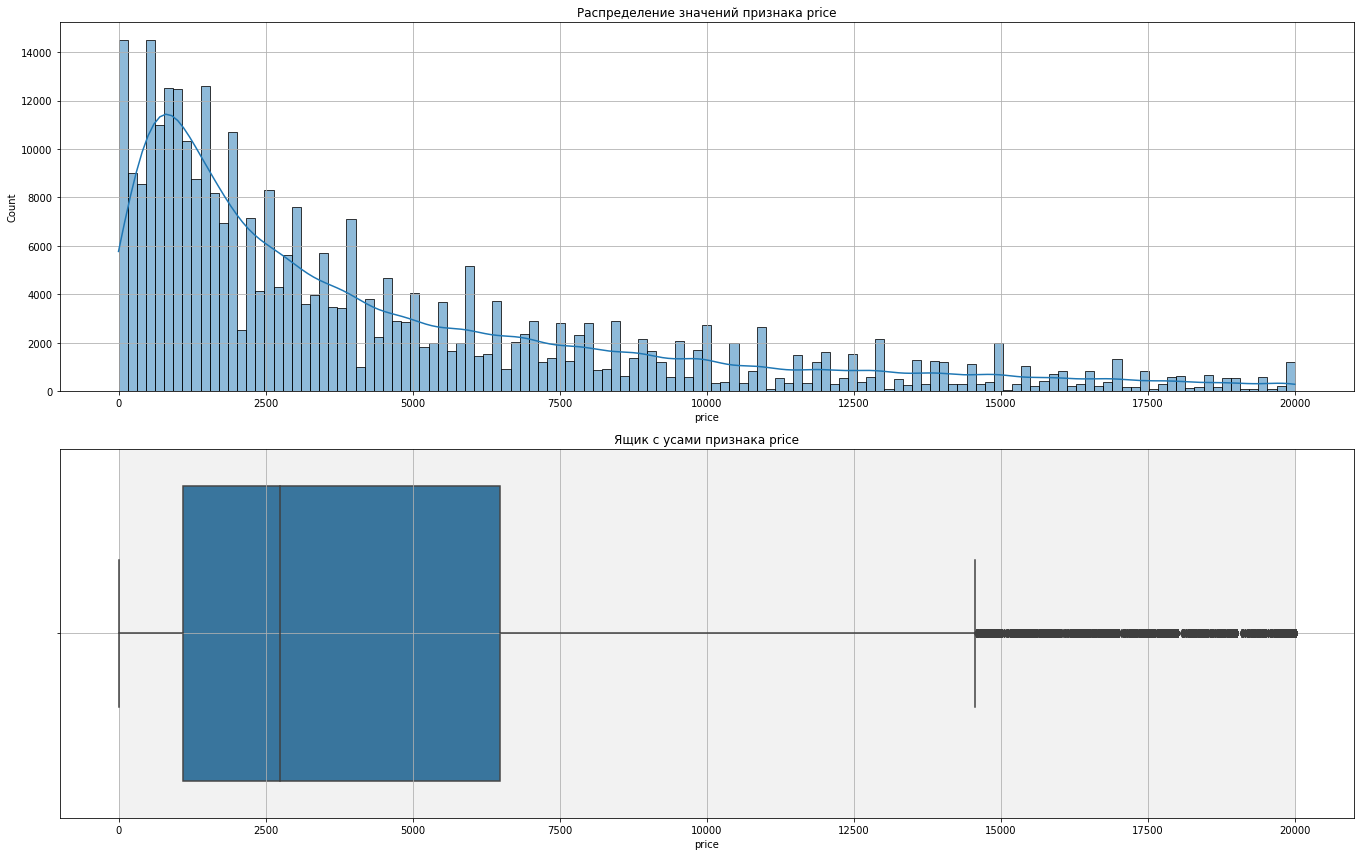

In [49]:
# Вызываем функцию для столбца 'price' в DataFrame 'data_auto'
desc_col_numeric('price', data_auto)

В целом распределение цены близко к распределению Пуассона за исключением аномалии в районе минимальных значений цены. Рассмотрим их подробнее.

Признак price :
count    11367.000000
mean         5.837600
std         18.829996
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         99.000000
Name: price, dtype: float64


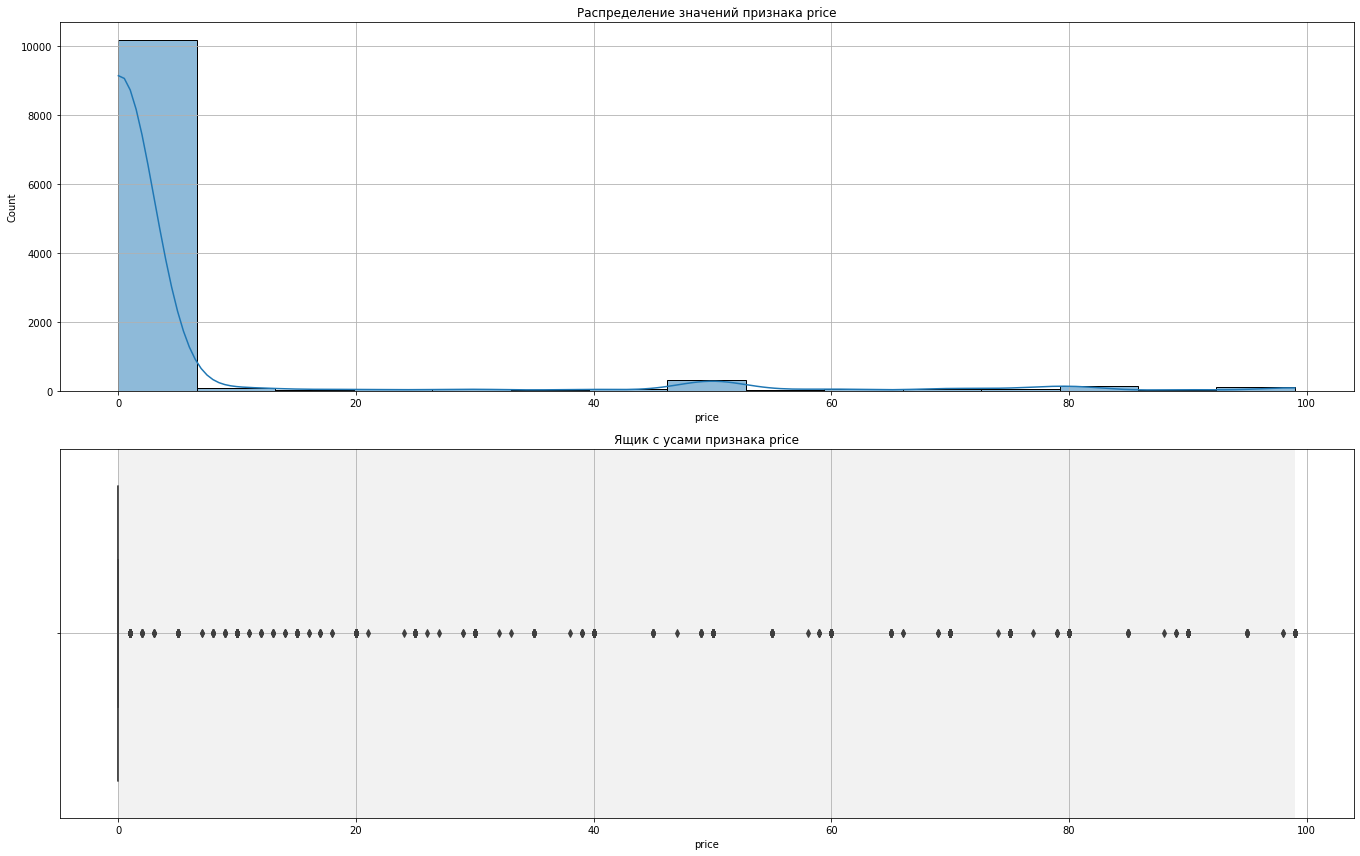

In [50]:
# Фильтруем датафрейм, чтобы получить только значения цены меньше 100
desc_col_numeric('price', data_auto.query('price < 100'))

Объявления, в которых цена указана как 0 или 1, не представляют интереса для анализа, так как эти значения могут быть ошибочными или неинформативными. Возможно, такие объявления относятся к категориям "отдам даром" или "цена по запросу", либо содержат ошибки в данных. Поэтому рекомендуется исключить эти объявления из рассмотрения при построении модели, так как они не предоставляют значимой информации.

In [51]:
# Исключение объявлений с ценой меньше или равной 1
data_auto = data_auto.query('price > 1')

На графике распределения цен не наблюдаются явных выбросов, которые бы соответствовали "красивым цифрам" (например, 11111, 5555, 2222). Поэтому нет оснований рассматривать такие значения как аномалии и исключать их из рассмотрения.

**Мощность (`power`)**

Оценим распределение мощности двигателя в представленном наборе данных.

Признак power :
count    321829.000000
mean        112.467313
std         183.023927
min           0.000000
25%          73.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


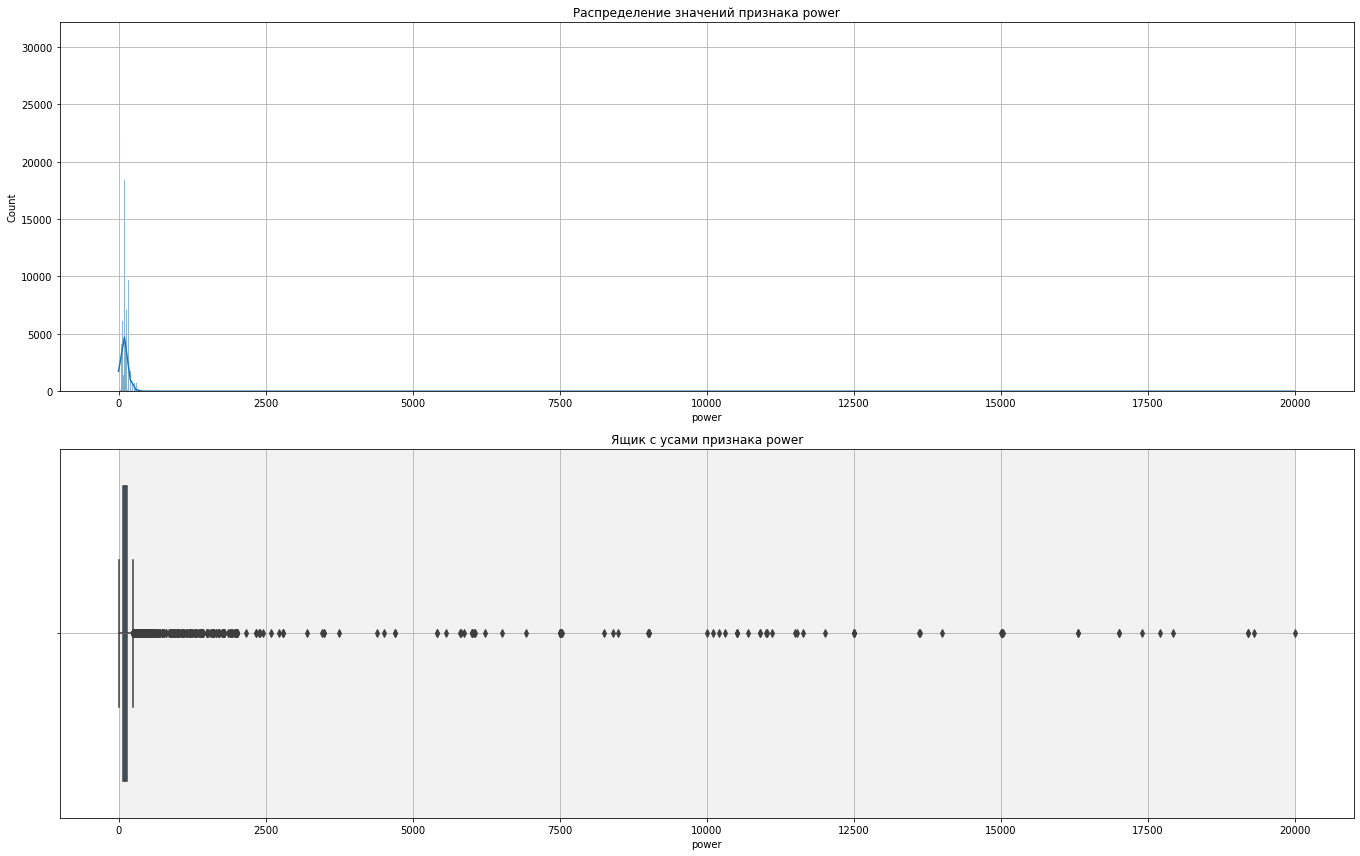

In [52]:
# Вызываем функцию для столбца 'power' в DataFrame 'data_auto'
desc_col_numeric('power', data_auto)

Межкартильный размах - (71, 143). Выбросы присутствуют как слева (значение 0), так и справа. Оценим указанные аномалии.

Признак power :
count    77315.000000
mean        34.904572
std         28.883597
min          0.000000
25%          0.000000
50%         50.000000
75%         60.000000
max         69.000000
Name: power, dtype: float64


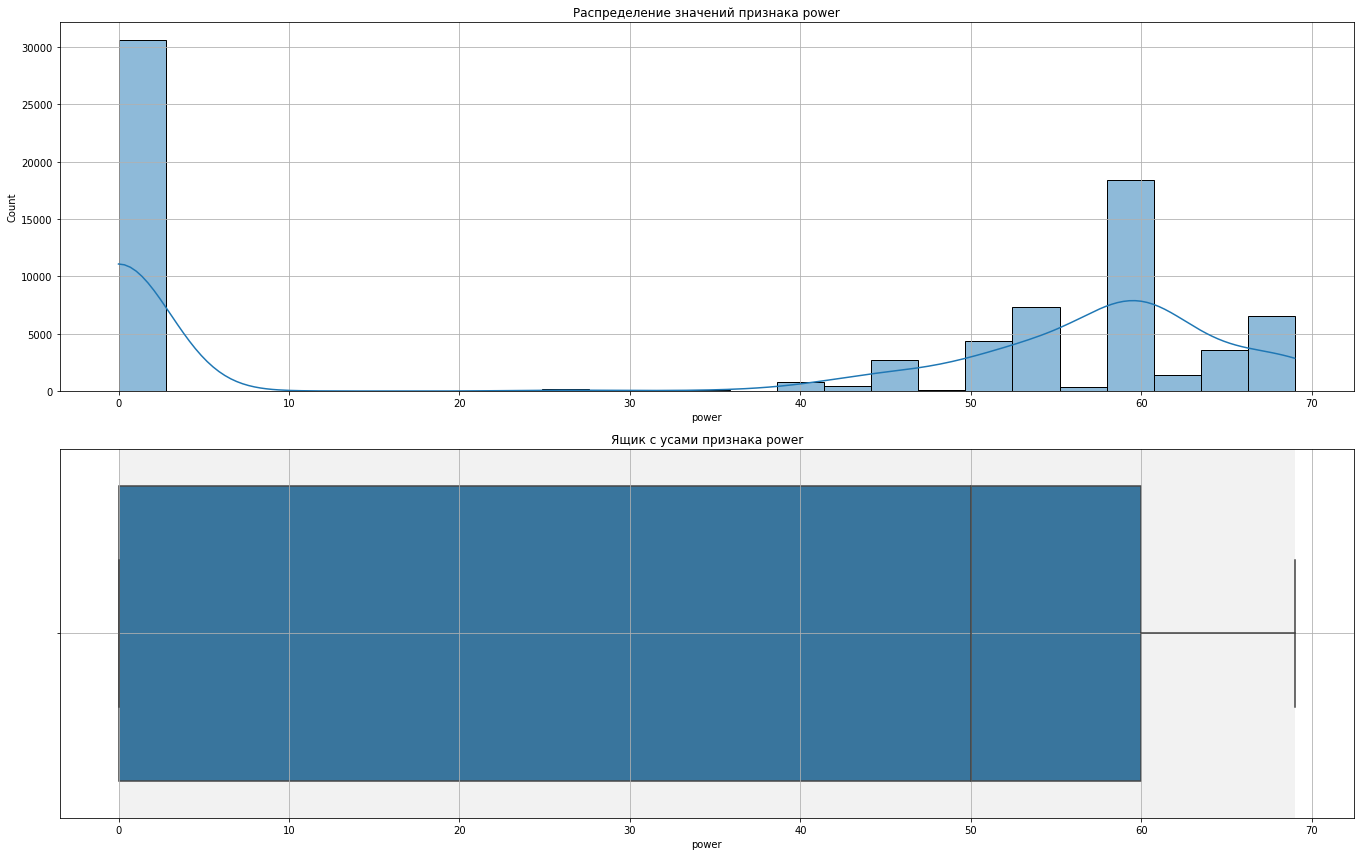

In [53]:
# Выбираем только те данные, где мощность меньше 70 л.с.
desc_col_numeric('power', data_auto.query('power < 70'))

In [54]:
# Вывод уникальных значений с процентным соотношением
print('Уникальные значения (процент):')
print(data_auto['power'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Уникальные значения (процент):
0        9.5%
75       6.8%
60       4.5%
150      4.2%
101      3.8%
         ... 
952      0.0%
776      0.0%
953      0.0%
17019    0.0%
8500     0.0%
Name: power, Length: 674, dtype: object


In [55]:
# Фильтруем данные и оставляем только те строки, где мощность больше 0 и меньше или равна 45
filtered_data = data_auto.query('power > 0 and power <= 45')

# Считаем количество объявлений со значением мощности в указанном интервале
count_in_interval = filtered_data['power'].count()

# Считаем долю объявлений со значением мощности в указанном интервале относительно общего количества объявлений
percentage = count_in_interval / data_auto.shape[0]

# Выводим результат в процентном формате с двумя знаками после запятой
print('Доля объявлений со значением мощности в интервале (1, 45): {0:.2%}'.format(percentage))

Доля объявлений со значением мощности в интервале (1, 45): 1.39%


Среди наблюдаемых выбросов в мощности автомобилей можно выделить две подгруппы:

- Значения мощности равные нулю: Вероятно, это объявления, в которых значение мощности не было указано. Доля таких объявлений составляет около 10% от общего объема данных.

- Значения мощности от 1 до 45: Доля таких объявлений составляет менее 1.4% от общего объема данных.

Предлагается заменить нулевые значения мощности на основе средних значений для каждого производителя и года производства. Однако это следует сделать после разделения данных на обучающую и тестовую выборки, чтобы избежать переобучения модели. Сначала необходимо собрать статистику на обучающей выборке и использовать ее для замены значений в обучающей и тестовой выборках.

Значения в диапазоне от 1 до 45 следует удалить как выбросы.

In [56]:
# data_auto.loc[(data_auto['power'] > 1000) | (data_auto['power'] <= 0), 'power'] = None
# data_auto['power'] = data_auto['power'].fillna(data_auto.groupby('model')['power'].transform('median'))
# data_auto = data_auto.loc[~data['power'].isna()]
# data_auto['power'] = data_auto['power'].astype('int64')

In [57]:
# Оставляем только строки, в которых значение мощности равно 0 или больше или равно 45
data_auto = data_auto.query('power == 0 or power >= 45')

Признак power :
count      256.000000
mean      4117.625000
std       4606.834153
min       1001.000000
25%       1384.250000
50%       1797.500000
75%       5828.000000
max      20000.000000
Name: power, dtype: float64


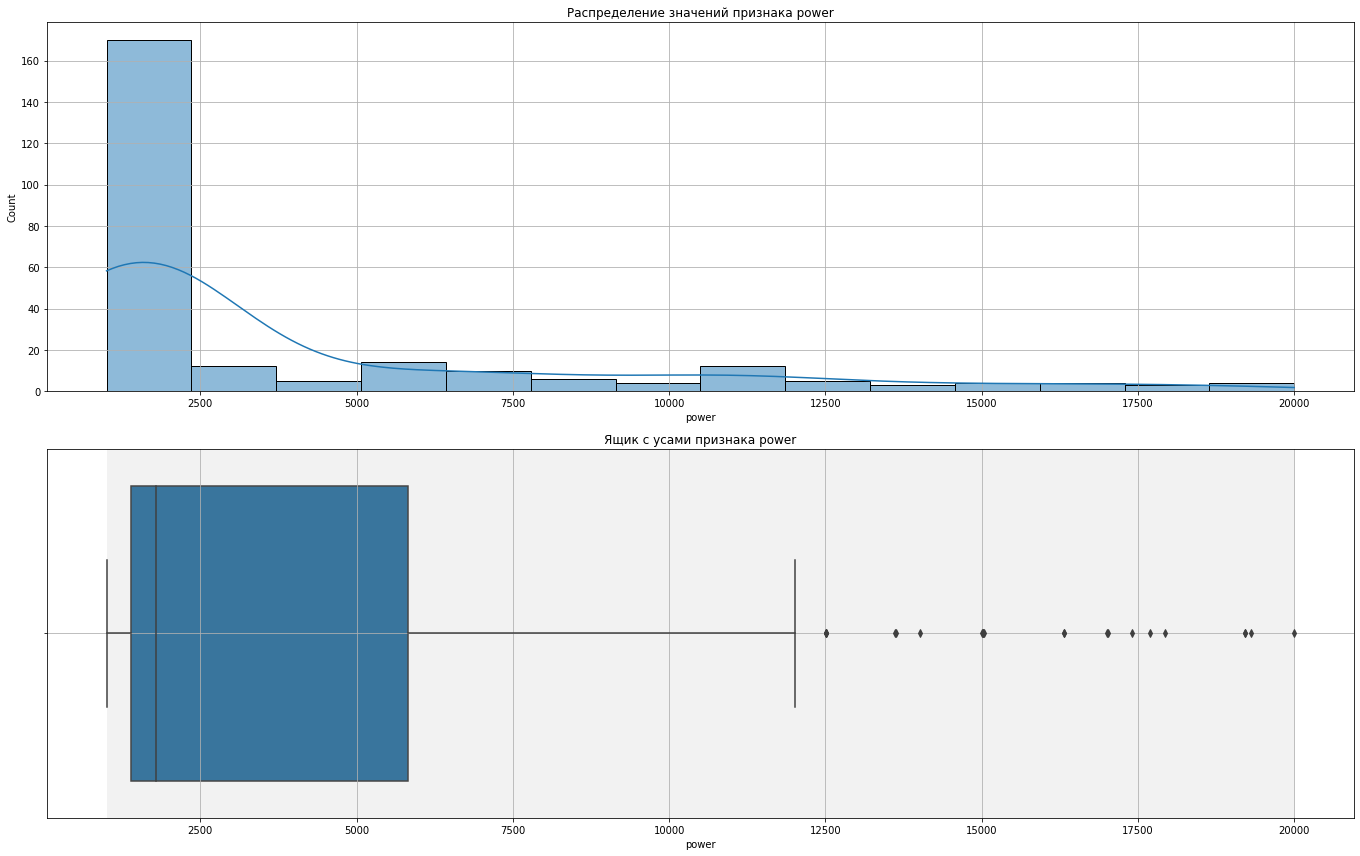

In [58]:
# Оцениваем статистики признака "мощность" для значений мощности, превышающих 1000
desc_col_numeric('power', data_auto.query('power > 1000'))

В правой зоне выбросов, соответствующей значениям мощности свыше `1000`, можно выделить две подзоны:

- Значения мощности до `3000` могут указывать на ошибку, где вместо мощности указан объем двигателя в литрах.
- Значения мощности свыше `3000` являются явными выбросами.

Целесообразно удалить объявления с указанием мощности свыше `3000`. В интервале от `1000` до `3000` предлагается произвести замену, разделив указанное значение на `20`. Это является средним переводным коэффициентом из объема двигателя в литрах в мощность в лошадиных силах. Хотя этот коэффициент может не совсем точно соответствовать современным двигателям, учитывая, что данные объявления представлены за длительный временной период, данное преобразование в целом можно считать достаточно корректным.

In [59]:
# Фильтрация данных: оставляем только объявления, где мощность не превышает 3000
data_auto = data_auto.query('power <= 3000')

In [60]:
# Создаем фильтр для значений мощности свыше 1000
filter_power = data_auto['power'] > 1000

# Вычисляем новые значения мощности, разделив текущие значения на 20
new_power_values = np.round(data_auto.query('power > 1000')['power'] / 20).astype('int')

# Заменяем значения мощности на новые значения для выбранных строк
data_auto.loc[filter_power, 'power'] = new_power_values

Признак power :
count    289370.000000
mean        121.263849
std          53.957787
min          45.000000
25%          80.000000
50%         113.000000
75%         150.000000
max        1000.000000
Name: power, dtype: float64


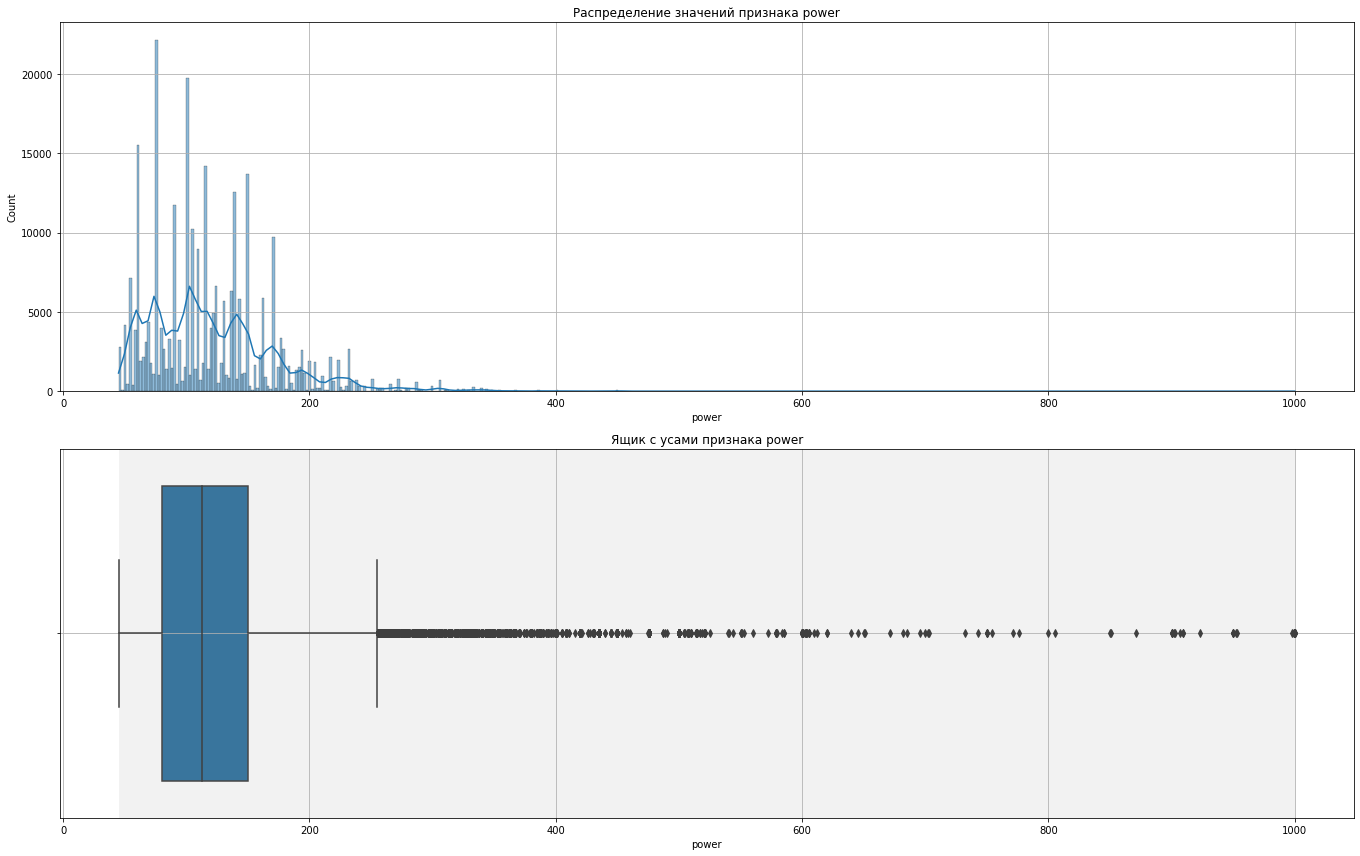

In [61]:
# Фильтруем данные, чтобы выбрать только значения мощности больше 0
desc_col_numeric('power', data_auto.query('power > 0'))

В целом, распределение значений мощности похоже на распределение Пуассона. Однако, наблюдаются характерные "пики" в некоторых значениях, которые объясняются шагом установки мощности производителями (например, значения 140 и 150 л.с.). В данном признаке непрерывность скорее является исключением, а не правилом.

Также, есть зона выбросов, где значения превышают 300 л.с. Однако, исключение этих данных нецелесообразно, так как в этой зоне присутствуют как ошибочные значения, так и верные данные.

In [62]:
# Отфильтровать DataFrame, выбрав строки, где значение мощности больше 400
data_auto.query('power > 400').head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,brand_type
2781,19500,suv,2004,auto,450,cayenne,125000,12,petrol,porsche,no,other
3289,16899,wagon,2003,auto,476,e_klasse,150000,9,petrol,mercedes_benz,no,mercedes_benz
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,other
4681,13900,sedan,2006,auto,476,e_klasse,150000,5,petrol,mercedes_benz,no,mercedes_benz
5319,10999,wagon,2006,auto,435,other,150000,12,petrol,audi,yes,audi
6296,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,other
6504,3000,small,2009,manual,771,punto,125000,1,petrol,fiat,NaN,fiat
6637,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,opel
8057,500,small,2002,manual,620,ypsilon,150000,12,petrol,lancia,NaN,other
10354,18900,wagon,2007,auto,420,3er,150000,12,petrol,bmw,no,bmw


**Пробег** (`kilometer`)

Оценим распределение значений пробега.

Признак kilometer :
count    319968.000000
mean     128988.961396
std       36672.542091
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


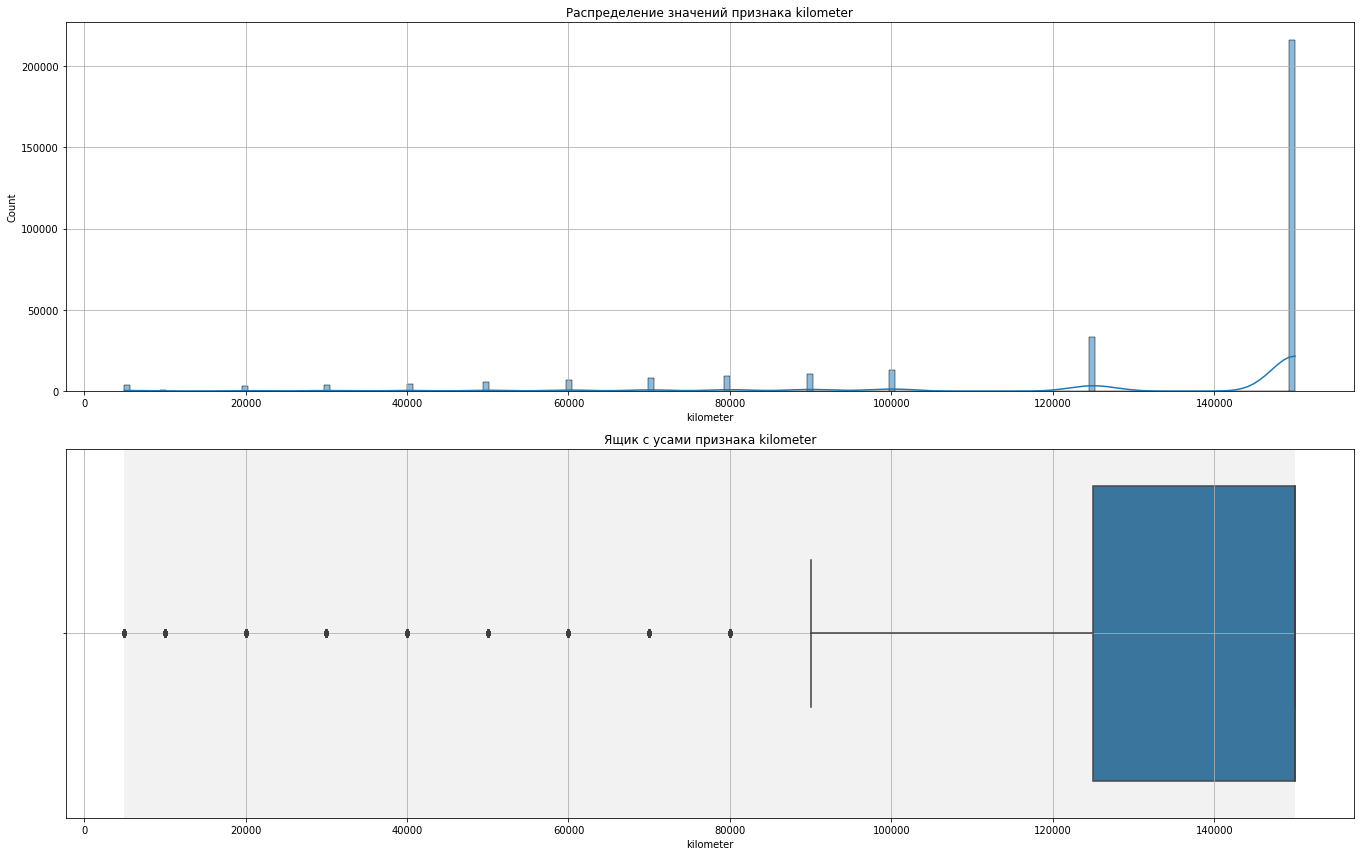

In [63]:
# Вызвать функцию desc_col_numeric с аргументами 'kilometer' и data_auto
desc_col_numeric('kilometer', data_auto)

Значения распределены в интервале от 5000 до 150000, в основном с шагом 10000. Вероятнее всего на ресурсе, с которого получены указанные объявления, ввод пробега осуществляется путем выбора из некоторого списка (судя по всему с ограничением: минимальное значение - от 0 до 5000, максимальное - свыше 150000).

В целом можно отметить, что признак пробега можно отнести к категориальным - количество уникальных значений ограничено (судя по всему, на указанном ресурсе выбор пробега осуществляется только путем выбора из списка значений).

**Признак выполнения ремонта (`repaired`)**

Оценим распределение значений признака выполнения ремонта.

Признак repaired :

Уникальные значения (процент):
no     87.9%
yes    12.1%
Name: repaired, dtype: object


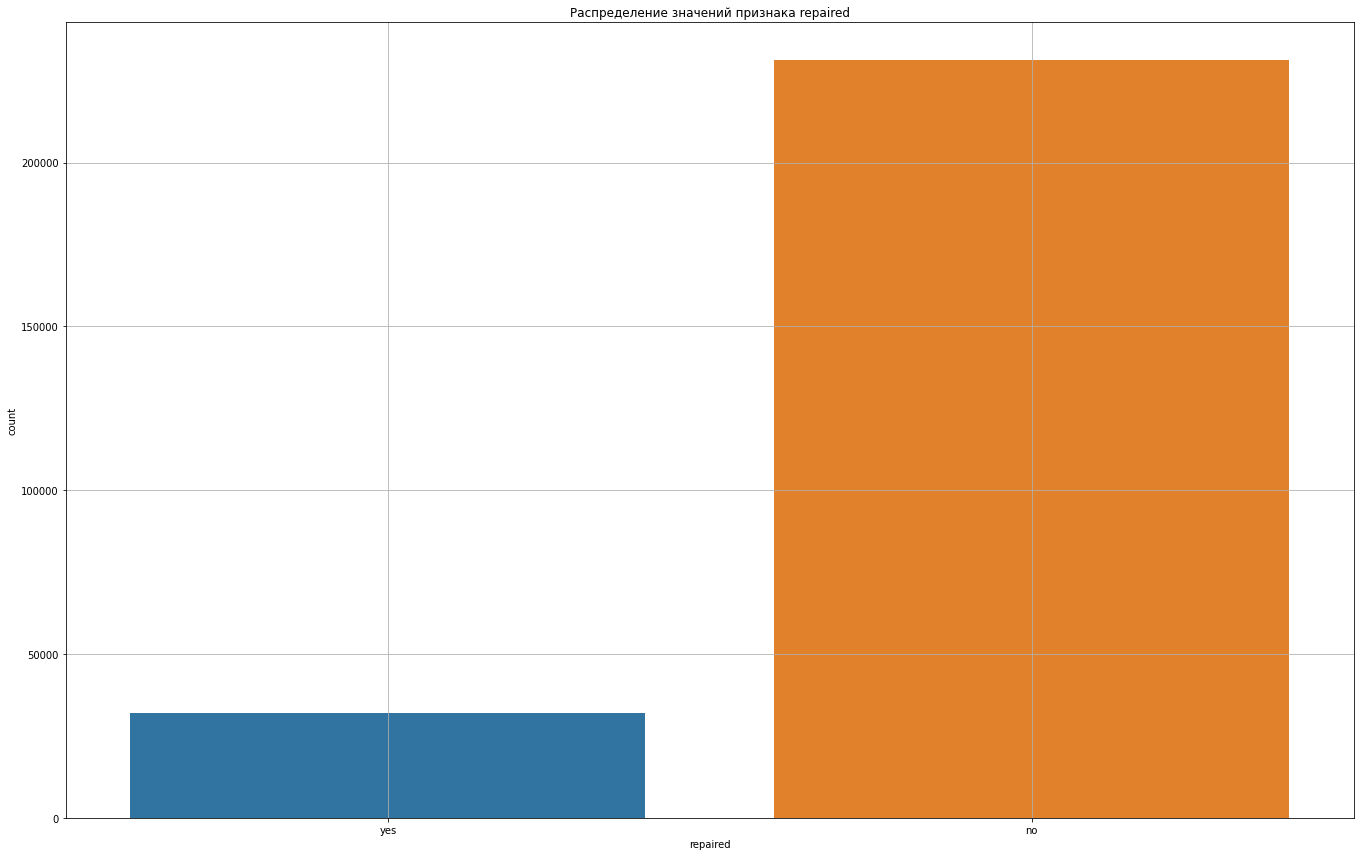

In [64]:
# Вызвать функцию desc_col_category с аргументами 'repaired' и data_auto
desc_col_category('repaired', data_auto)

In [65]:
# Вычислить количество пропущенных значений в столбце 'repaired'
null_count = data_auto['repaired'].isnull().sum()

# Вычислить общее количество строк в DataFrame data_auto
total_count = data_auto.shape[0]

# Вычислить долю объявлений с пропусками в столбце 'repaired'
null_percentage = null_count / total_count

# Вывести долю пропущенных значений в признаке выполнения ремонта
print('Доля объявлений с пропусками в признаке выполнения ремонта: {0:.2%}'.format(null_percentage))

Доля объявлений с пропусками в признаке выполнения ремонта: 17.77%


Разумно заменить пропущенные значения в признаке выполнения ремонта на отдельную категорию "unknown". Это обусловлено тем, что отсутствие информации о ремонте отличается от явного указания, что автомобиль не был ремонтирован. Замена на наиболее частое значение нецелесообразна, так как неправильно предполагать, что все объявления без информации о ремонте подразумевают, что автомобиль не требовал ремонта.

In [66]:
# Заменяем пропущенные значения в признаке выполнения ремонта на категорию 'unknown'
data_auto['repaired'] = data_auto['repaired'].fillna('unknown')

Признак repaired :

Уникальные значения (процент):
no         72.3%
unknown    17.8%
yes        10.0%
Name: repaired, dtype: object


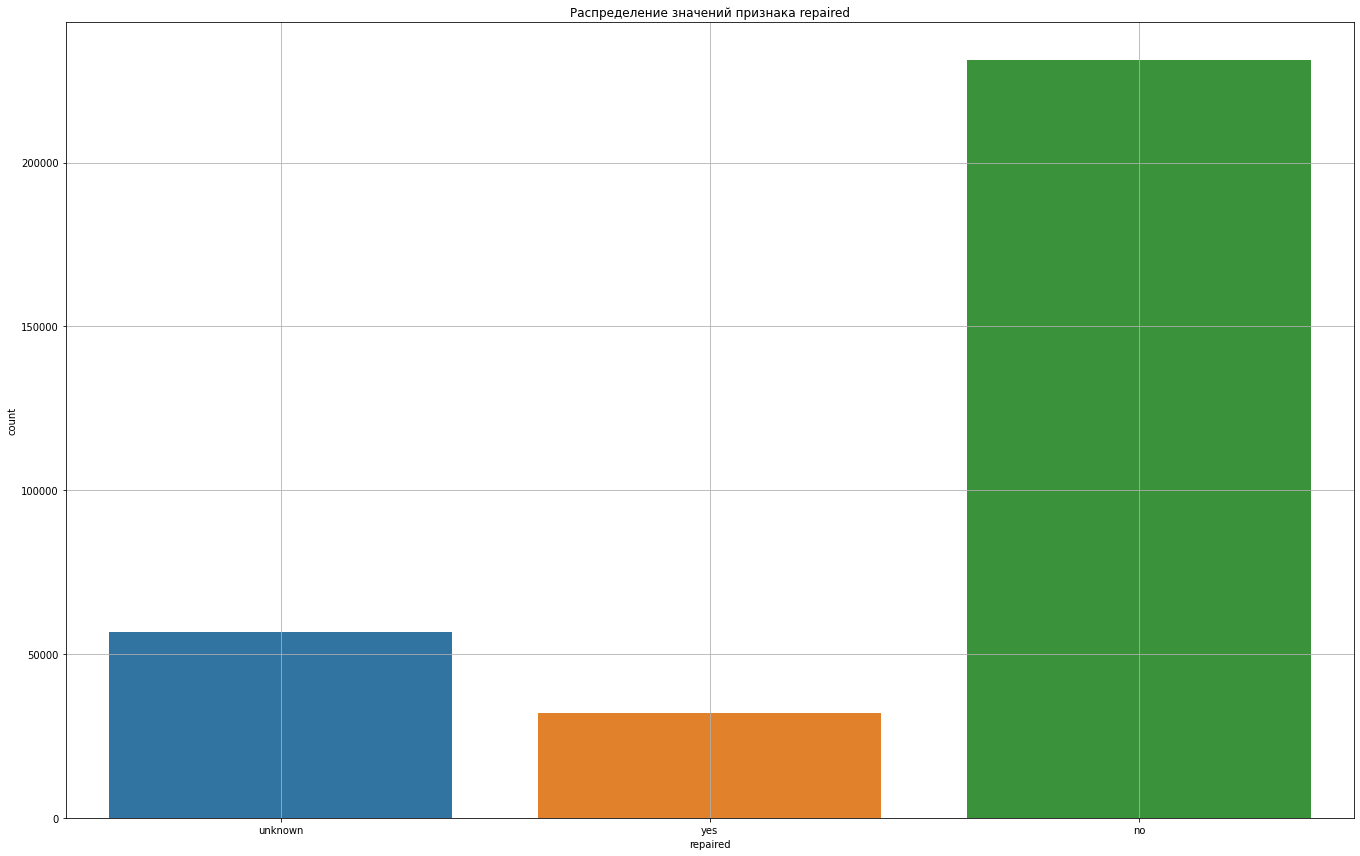

In [67]:
# Вычисляем количество уникальных значений и их частоту в признаке 'repaired'
desc_col_category('repaired', data_auto)

**Тип топлива (`fuel_type`)**

Оценим распределение значений признака типа топлива.

Признак fuel_type :

Уникальные значения (процент):
petrol      66.7%
gasoline    31.4%
lpg          1.6%
cng          0.2%
hybrid       0.1%
other        0.0%
electric     0.0%
Name: fuel_type, dtype: object


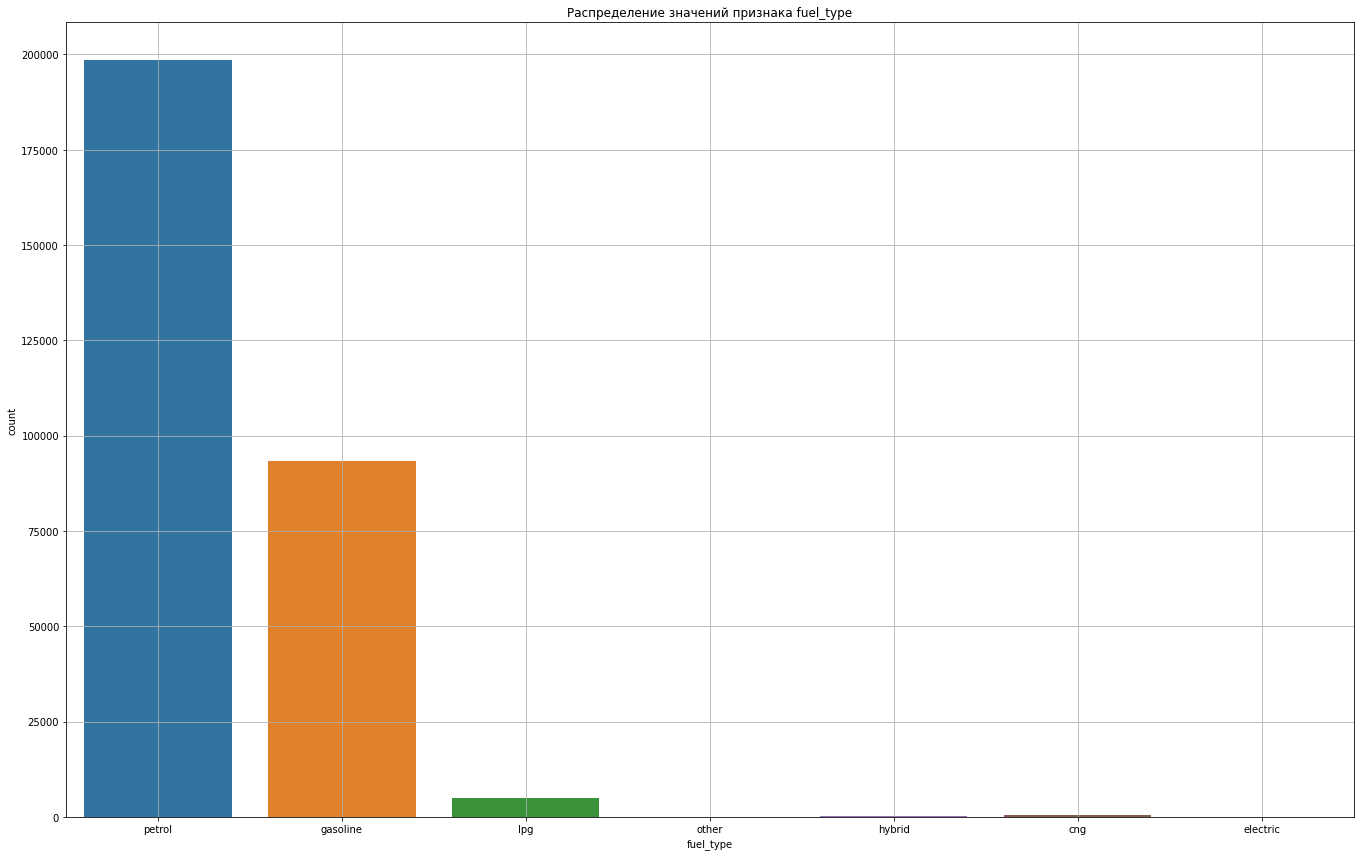

In [68]:
# Вычисляем количество уникальных значений и их частоту в признаке 'fuel_type'
desc_col_category('fuel_type', data_auto)

In [69]:
# Вычисляем количество пропущенных значений в признаке 'fuel_type'
missing_values = data_auto['fuel_type'].isnull().sum()

# Вычисляем долю пропущенных значений относительно всего объема данных
missing_values_percentage = missing_values / data_auto.shape[0]

# Выводим результаты
print('Доля объявлений с пропусками в признаке типа топлива: {0:.2%}'.format(missing_values_percentage))

Доля объявлений с пропусками в признаке типа топлива: 6.97%


Распределение типов топлива в данных является крайне неравномерным, преобладающие категории - petrol и gasoline, которые составляют около 98% от общего числа записей. В связи с этим предлагается выполнить следующие действия:

- Объединить категории petrol и gasoline в одну категорию.
- Заменить отсутствующие значения (учитывая их значительное количество относительно всего набора данных) на наиболее часто встречающуюся категорию - petrol.
- Оценить распределение после проведенных изменений.

In [70]:
# Заменяем категорию 'gasoline' на 'petrol'
data_auto.loc[data_auto['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

In [71]:
# Заполняем пропущенные значения в столбце 'fuel_type' значением 'petrol'
data_auto['fuel_type'] = data_auto['fuel_type'].fillna('petrol')

Признак fuel_type :

Уникальные значения (процент):
petrol      98.2%
lpg          1.5%
cng          0.2%
hybrid       0.1%
other        0.0%
electric     0.0%
Name: fuel_type, dtype: object


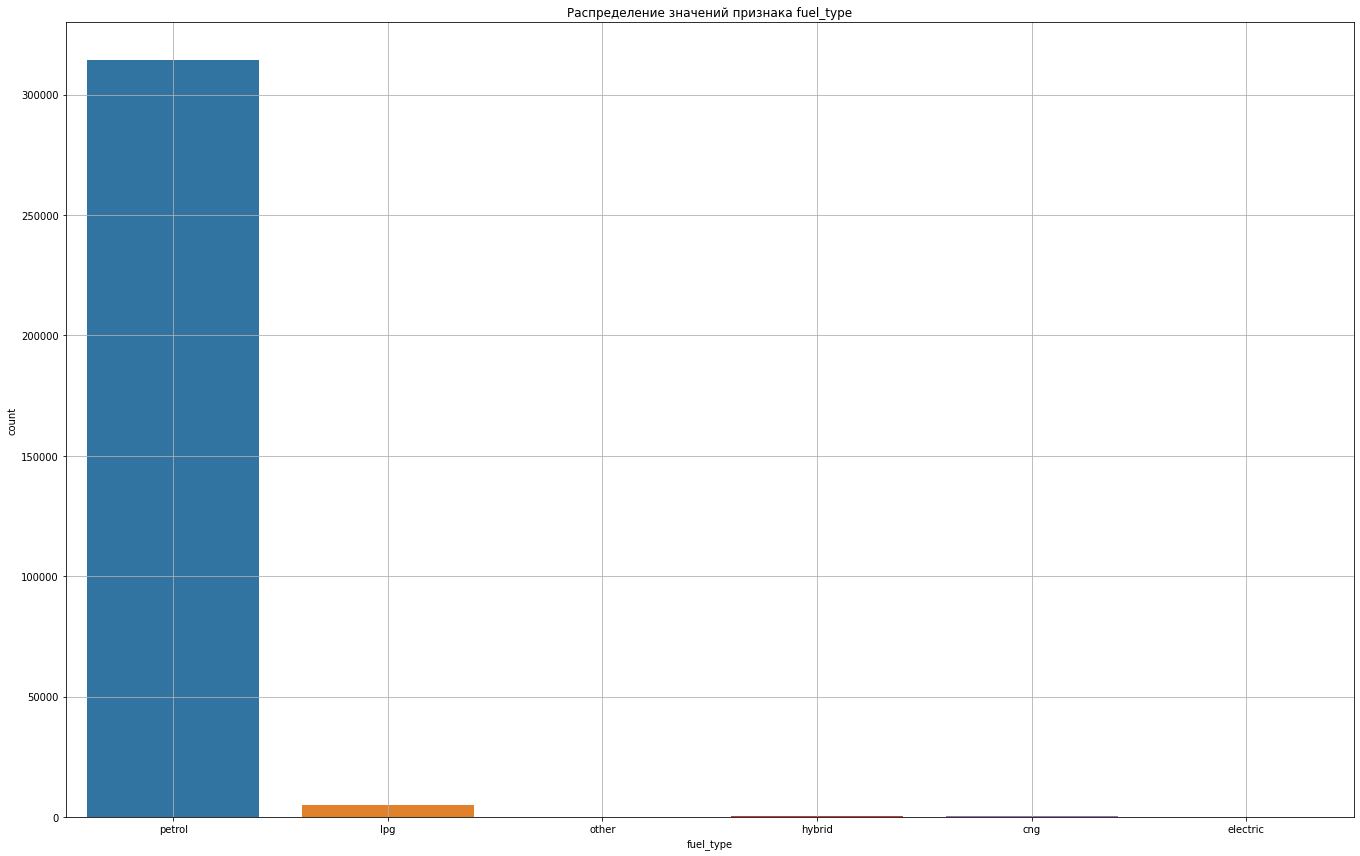

In [72]:
# Считаем количество уникальных значений в столбце 'fuel_type'
desc_col_category('fuel_type', data_auto)

Можно объединить категории `lpg` (сжиженный газ) и `cng` (сжатый природный газ) в одну категорию, так как они относятся к газовому виду топлива. Остальные категории, такие как гибридные и электрические двигатели, которые имеют небольшой объем предложений, можно исключить из рассмотрения.

In [73]:
# Заменяем категорию 'lpg' на 'gas'
data_auto.loc[data_auto['fuel_type'] == 'lpg', 'fuel_type'] = 'gas'

# Заменяем категорию 'cng' на 'gas'
data_auto.loc[data_auto['fuel_type'] == 'cng', 'fuel_type'] = 'gas'

In [74]:
# Оставляем только категории 'petrol' и 'gas'
data_auto = data_auto.query('fuel_type in (\'petrol\', \'gas\')')

Признак fuel_type :

Уникальные значения (процент):
petrol    98.3%
gas        1.7%
Name: fuel_type, dtype: object


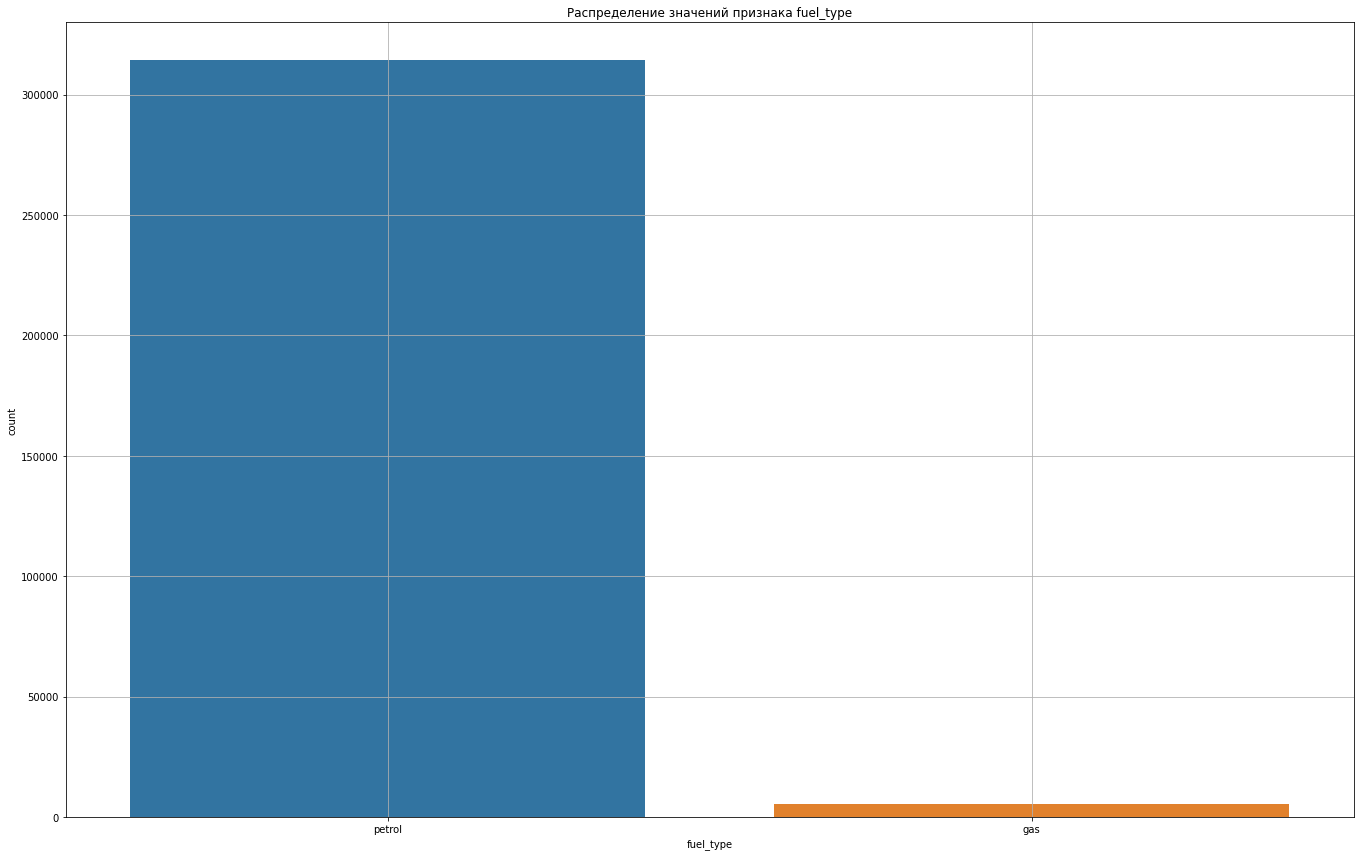

In [75]:
# Выводим описательные статистики для признака 'fuel_type'
desc_col_category('fuel_type', data_auto)

**Модель автомобиля (`model`)**

Оценим распределение значений признака модели.

Признак model :

Уникальные значения (процент):
golf                  8.6%
other                 6.7%
3er                   6.0%
polo                  3.9%
corsa                 3.7%
                      ... 
i3                    0.0%
elefantino            0.0%
kalina                0.0%
rangerover            0.0%
range_rover_evoque    0.0%
Name: model, Length: 247, dtype: object


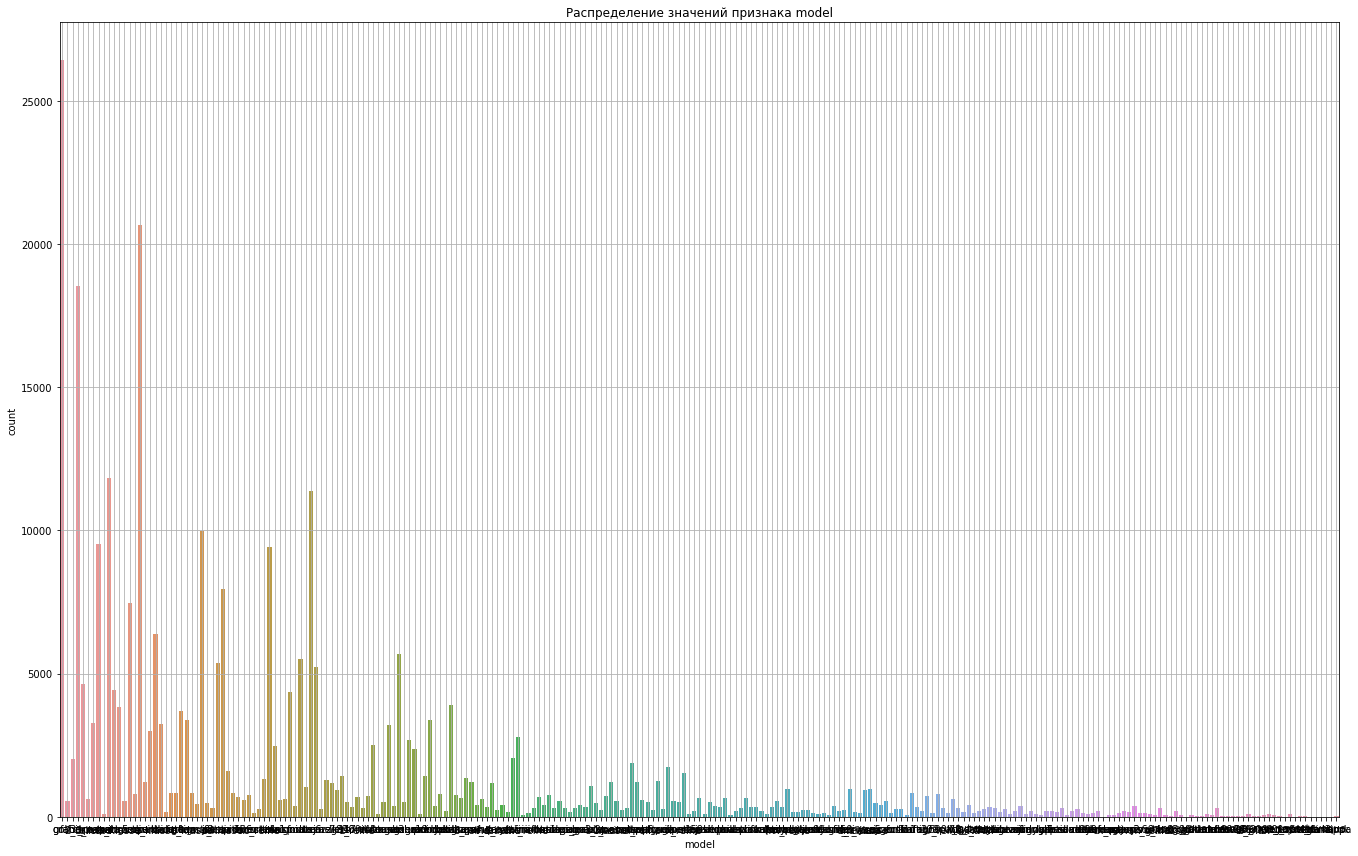

In [76]:
# Выводим описательные статистики для признака 'model'
desc_col_category('model', data_auto)

In [77]:
# Вычисляем долю объявлений с пропусками в признаке 'model'
missing_ratio = data_auto['model'].isnull().sum() / data_auto.shape[0]

# Выводим долю объявлений с пропусками в признаке модели
print('Доля объявлений с пропусками в признаке модели: {0:.2%}'.format(missing_ratio))

Доля объявлений с пропусками в признаке модели: 3.87%


Учитывая, что в данных есть пропуски в признаке модели (примерно `4.2%` от всех записей) и категория `'other'` (прочие модели), которая составляет около `6.6%` от всех записей, целесообразно заменить пропуски в признаке модели на значение `'other'`. Это позволит унифицировать обработку пропущенных значений и учесть модели, которые представлены в небольшом количестве.

In [78]:
# Заменяем пропущенные значения в признаке 'model' на категорию 'other'
data_auto['model'] = data_auto['model'].fillna('other')

Учитывая большое количество уникальных значений в признаке модели (около 250), целесообразно создать дополнительный признак, который будет содержать наиболее популярные модели, а остальные модели объединить в категорию "прочие". Эту операцию можно выполнить на этапе подготовки обучающей и тестовой выборок, используя статистику из обучающей выборки. Таким образом, мы упростим модель и сократим количество уникальных значений, что может быть полезным для обучения ML-модели.

**Тип коробки передач (`gearbox`)**

Оценим распределение значений признака типа коробки передач.

Признак gearbox :

Уникальные значения (процент):
manual    80.2%
auto      19.8%
Name: gearbox, dtype: object


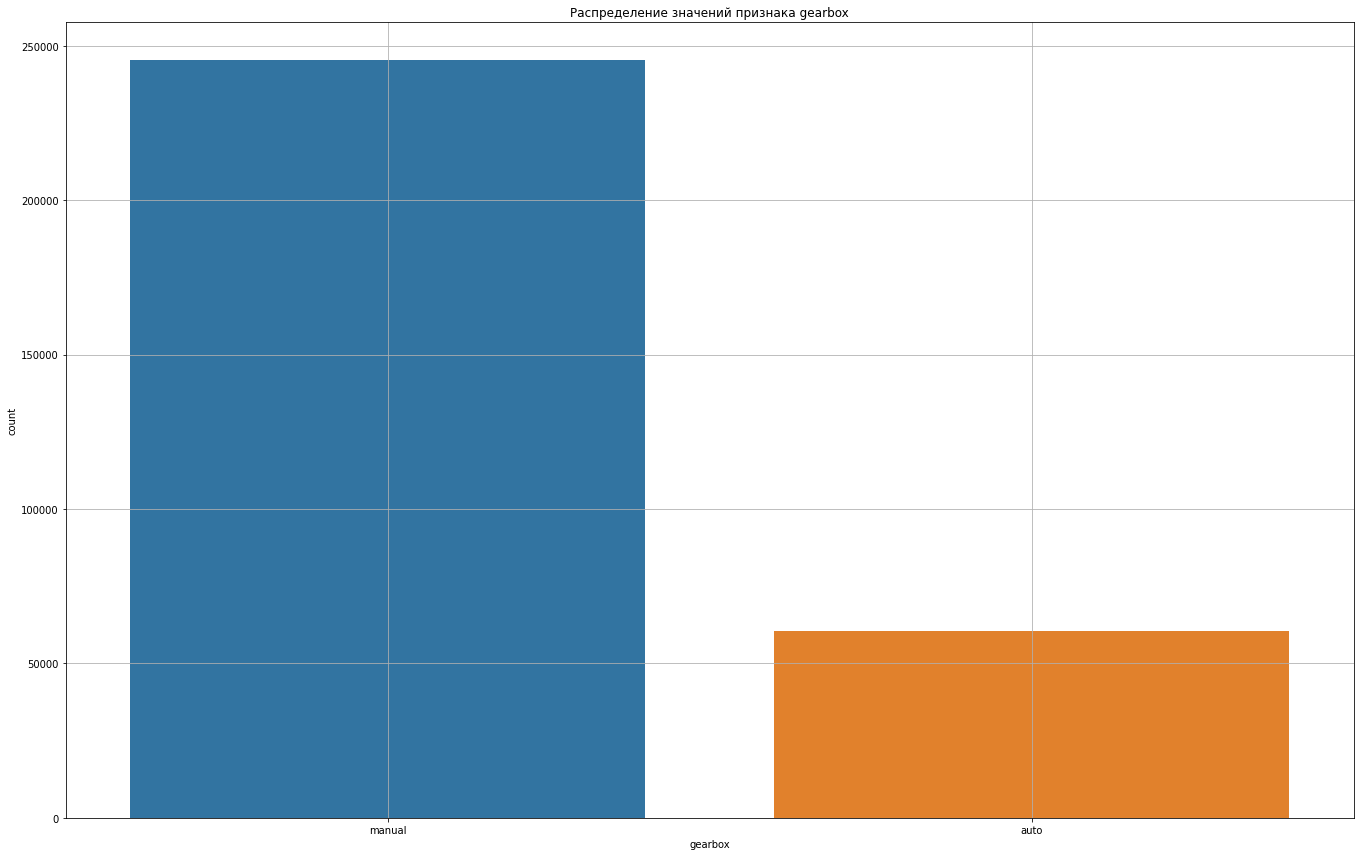

In [79]:
# Вызвать функцию для признака 'gearbox' в DataFrame 'data_auto'
desc_col_category('gearbox', data_auto)

In [80]:
# Подсчитать долю пропущенных значений в признаке 'gearbox'
missing_ratio = data_auto['gearbox'].isnull().sum() / data_auto.shape[0]

# Вывести результат с помощью форматирования строки
print('Доля объявлений с пропусками в признаке типа коробки передач: {0:.2%}'.format(missing_ratio))

Доля объявлений с пропусками в признаке типа коробки передач: 4.34%


Соотношение между ручной и автоматической коробкой передач составляет примерно 4 к 1. Учитывая относительно небольшое количество пропущенных значений, нет необходимости создавать отдельную категорию (например, `"unknown"`). Вместо этого, целесообразно заменить пропущенные значения на наиболее распространенную категорию - `"manual"`.

In [81]:
# Замена пропущенных значений в признаке 'gearbox' на 'manual'
data_auto['gearbox'] = data_auto['gearbox'].fillna('manual')

Признак gearbox :

Уникальные значения (процент):
manual    81.1%
auto      18.9%
Name: gearbox, dtype: object


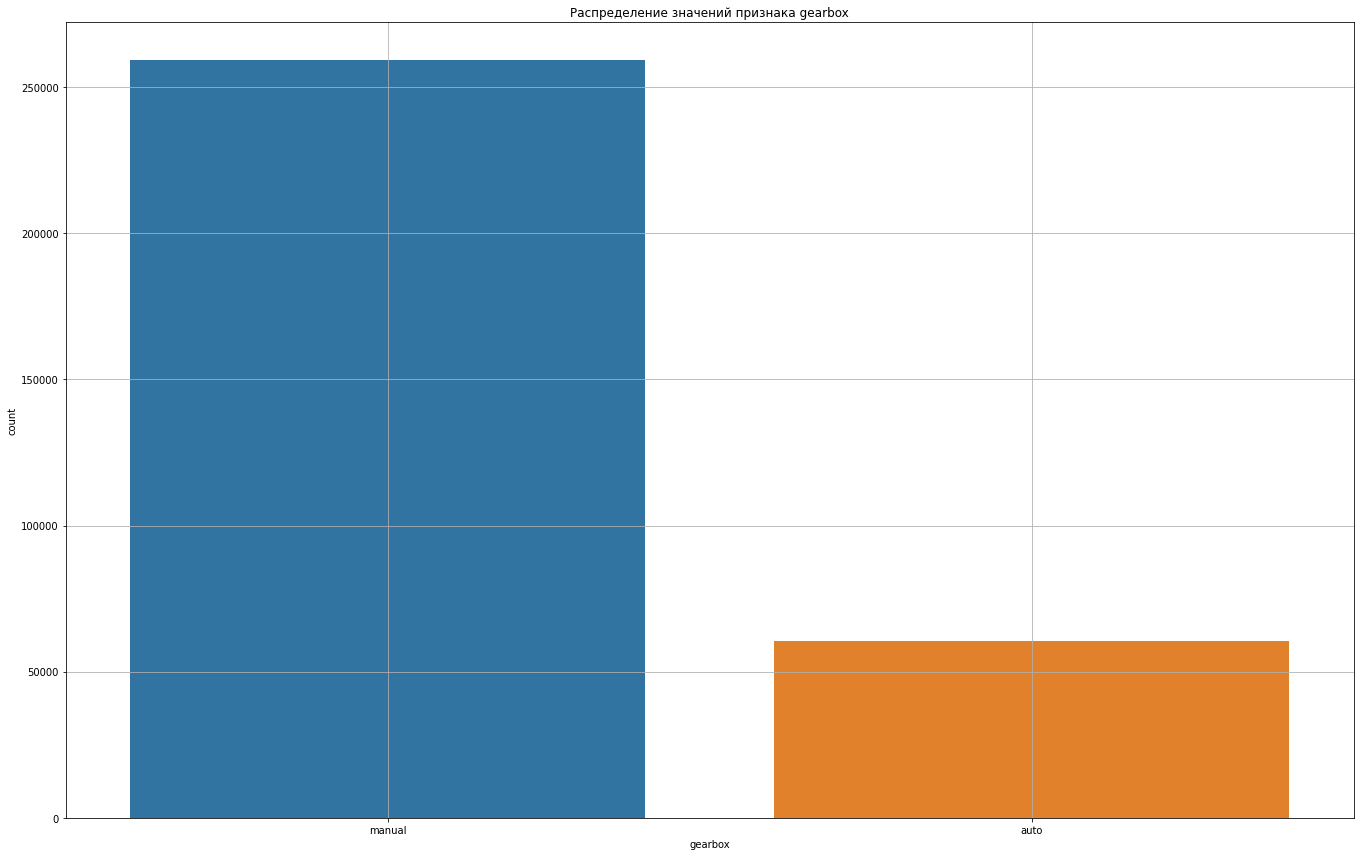

In [82]:
# Описательные статистики для признака 'gearbox'
desc_col_category('gearbox', data_auto)

В целом соотношение ручная/автоматическая коробка передач не сильно изменилось.

**Тип кузова (`vehicle_type`)**

Оценим распределение значений признака типа кузова.

Признак vehicle_type :

Уникальные значения (процент):
sedan          28.9%
small          25.2%
wagon          21.0%
bus             9.3%
convertible     6.3%
coupe           4.8%
suv             3.7%
other           0.9%
Name: vehicle_type, dtype: object


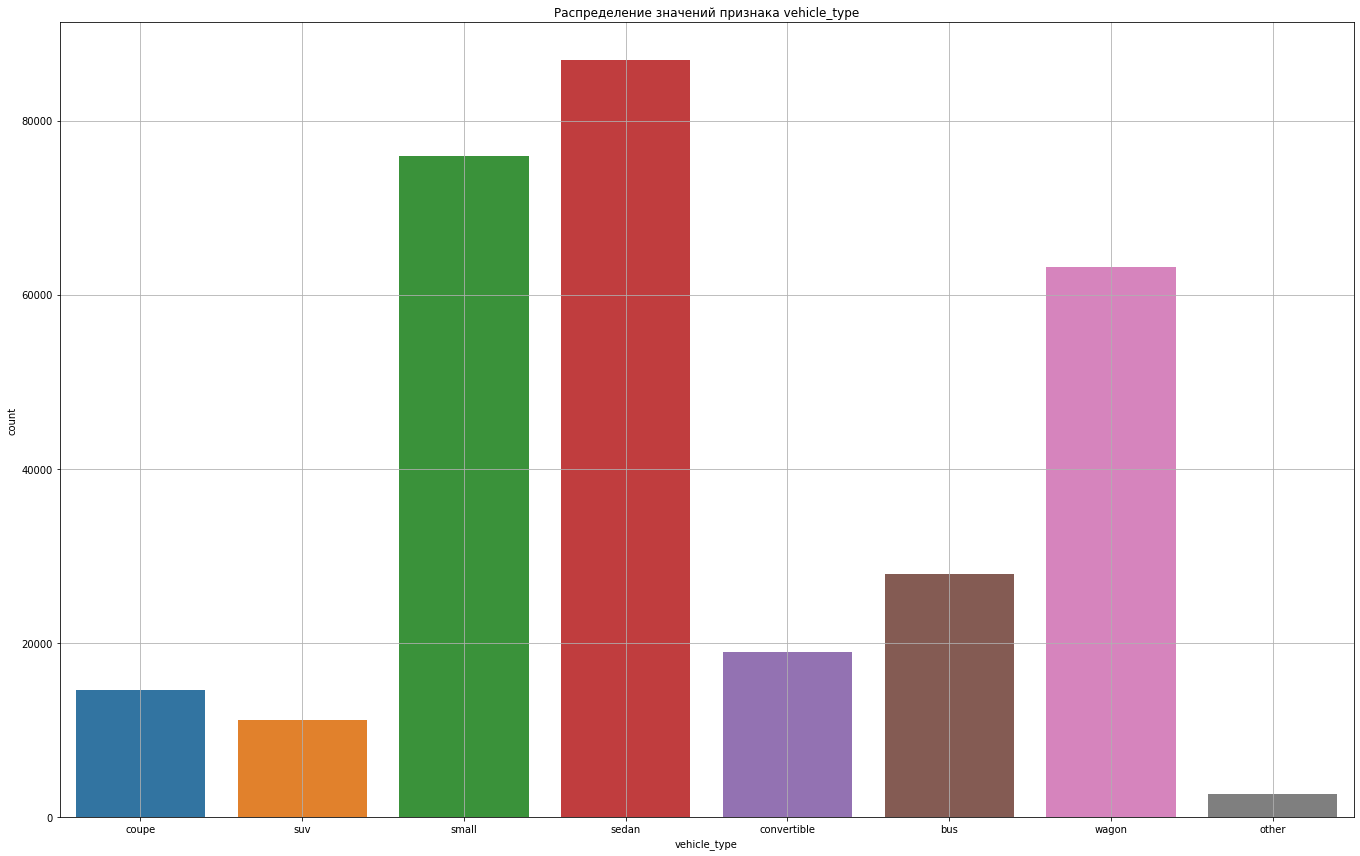

In [83]:
# Описательные статистики для признака 'vehicle_type'
desc_col_category('vehicle_type', data_auto)

In [84]:
# Вычисление доли пропущенных значений в признаке 'vehicle_type'
missing_percentage = data_auto['vehicle_type'].isnull().sum() / data_auto.shape[0]

# Вывод доли пропущенных значений
print('Доля объявлений с пропусками в признаке типа кузова: {0:.2%}'.format(missing_percentage))

Доля объявлений с пропусками в признаке типа кузова: 5.80%


In [85]:
# Выборка всех записей, где признак 'vehicle_type' имеет пропущенное значение
data_auto.query('vehicle_type.isnull()', engine='python')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,brand_type
0,480,NaN,1993,manual,0,golf,150000,1,petrol,volkswagen,unknown,volkswagen
16,300,NaN,2016,manual,60,polo,150000,5,petrol,volkswagen,unknown,volkswagen
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,unknown,renault
35,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,volkswagen
37,1500,NaN,2016,manual,0,kangoo,150000,1,petrol,renault,no,renault
...,...,...,...,...,...,...,...,...,...,...,...,...
354336,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,unknown,other
354338,180,NaN,1995,manual,0,other,125000,3,petrol,opel,unknown,opel
354346,2600,NaN,2005,auto,0,c_klasse,150000,9,petrol,mercedes_benz,unknown,mercedes_benz
354351,1900,NaN,2000,manual,110,other,150000,7,petrol,volkswagen,no,volkswagen


Для признака "тип кузова" у нас много пропущенных данных, но для некоторых записей у нас есть информация о марке и модели автомобиля. Это позволяет нам выполнить замену пропущенных значений на наиболее распространенный тип кузова для каждой модели.

Аналогично, как и с признаком "мощность", чтобы не переобучить модель, мы выполним эту операцию после разделения данных на обучающую и тестовую выборки. Таким образом, мы соберем статистику по типу кузова на обучающей выборке и затем заменим значения как в обучающей, так и в тестовой выборке на наиболее часто встречающийся тип кузова для каждой модели.

# Выводы

После оценки распределения значений признаков в объявлениях было проведено исключение или замена аномалий и пропущенных значений.

Объявления с неправдоподобно долгим периодом экспозиции были исключены, так как могли содержать недостоверные ценовые данные.

В признаке года регистрации автомобилей были исключены аномальные значения и выбросы, которые не отражают текущее состояние рынка автомобилей.

Для числовых и категориальных признаков также были устранены аномалии и выполнена замена пропущенных значений. В случае дальнейшего использования модели, эти операции могут быть автоматизированы и применены к новым данным, не зависимо от конкретных представленных данных.

Некоторые операции замены, например, замена значения 0 в признаке мощности автомобиля, целесообразно выполнить после разделения данных на обучающую и тестовую выборки. Сначала собирается статистика на обучающей выборке, а затем значения заменяются как в обучающей, так и в тестовой выборке.

В целом, проведенные операции помогли устранить аномалии, заполнить пропущенные значения и подготовить данные для дальнейшего анализа и обучения модели.

## Подготовьте выборки для обучения моделей.

**Разделение данных на обучающую и тестовую выборку**

Для разделения данных на обучающую, валидационную и тестовую выборки мы будем использовать стратифицированный подход, с учетом признака `brand_type`, который был добавлен ранее. Этот признак позволяет разделить производителей автомобилей на две группы: тех, которые занимают более `1%` рынка, и тех, у которых доля рынка небольшая.

Таким образом, разделение данных будет учитывать пропорциональное распределение производителей в обучающей и тестовой выборках, чтобы обеспечить баланс между классами в обоих наборах данных.

In [86]:
# Разделение данных на обучающую и тестовую выборку
# data_auto: исходный датасет
# test_size=0.2: размер тестовой выборки, 20% от исходных данных
# random_state=random_state: задание случайного состояния для воспроизводимости результатов
# stratify=data_auto['brand_type']: стратификация по признаку 'brand_type'
data_train, data_test = train_test_split(
    data_auto, 
    test_size=0.2, 
    random_state=random_state, 
    stratify=data_auto['brand_type']
)

In [87]:
# Разделение данных на обучающую+валидационную выборку и тестовую выборку
data_train_val, data_test = train_test_split(
    data_auto,
    test_size=0.2,
    random_state=random_state,
    stratify=data_auto['brand_type']
)

# Разделение обучающей+валидационной выборки на обучающую выборку и валидационную выборку
data_train, data_val = train_test_split(
    data_train_val,
    test_size=0.2,
    random_state=random_state,
    stratify=data_train_val['brand_type']
)

Для замены пропущенных значений и аномалий в признаках мы собираем статистические данные на основе информации, имеющейся в обучающей выборке. Конкретно, мы собираем информацию о значениях мощности и типе кузова для каждого производителя и модели автомобиля. Затем, используя эти статистические данные, мы заменим пропущенные значения и аномалии в признаках на соответствующих производителей и моделях автомобилей в тестовой выборке. Это позволит улучшить качество данных и обеспечить более точные результаты обучения модели на обучающей выборке.

<div class="alert alert-block alert-success">
<b>Успех:</b> Мне нравится подход


**Заполнение пропусков на основе статистики в обучающей выборке**

In [88]:
# Выводим информацию о структуре и типах данных в обучающей выборке data_train
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204568 entries, 308392 to 133920
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               204568 non-null  int64 
 1   vehicle_type        192653 non-null  object
 2   registration_year   204568 non-null  int64 
 3   gearbox             204568 non-null  object
 4   power               204568 non-null  int64 
 5   model               204568 non-null  object
 6   kilometer           204568 non-null  int64 
 7   registration_month  204568 non-null  int64 
 8   fuel_type           204568 non-null  object
 9   brand               204568 non-null  object
 10  repaired            204568 non-null  object
 11  brand_type          204568 non-null  object
dtypes: int64(5), object(7)
memory usage: 20.3+ MB


In [89]:
# Выводим информацию о структуре и типах данных в обучающей выборке data_val
data_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51143 entries, 343978 to 10450
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               51143 non-null  int64 
 1   vehicle_type        48206 non-null  object
 2   registration_year   51143 non-null  int64 
 3   gearbox             51143 non-null  object
 4   power               51143 non-null  int64 
 5   model               51143 non-null  object
 6   kilometer           51143 non-null  int64 
 7   registration_month  51143 non-null  int64 
 8   fuel_type           51143 non-null  object
 9   brand               51143 non-null  object
 10  repaired            51143 non-null  object
 11  brand_type          51143 non-null  object
dtypes: int64(5), object(7)
memory usage: 5.1+ MB


In [90]:
# Выводим информацию о структуре и типах данных в обучающей выборке data_test
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63928 entries, 57620 to 77319
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               63928 non-null  int64 
 1   vehicle_type        60227 non-null  object
 2   registration_year   63928 non-null  int64 
 3   gearbox             63928 non-null  object
 4   power               63928 non-null  int64 
 5   model               63928 non-null  object
 6   kilometer           63928 non-null  int64 
 7   registration_month  63928 non-null  int64 
 8   fuel_type           63928 non-null  object
 9   brand               63928 non-null  object
 10  repaired            63928 non-null  object
 11  brand_type          63928 non-null  object
dtypes: int64(5), object(7)
memory usage: 6.3+ MB


**Мощность (`power`)**

Определим медианное значение мощности для каждого производителя и модели автомобиля на основе данных обучающей выборки.

In [91]:
# Выбираем только ненулевые значения мощности для производителей, не относящихся к основным
filtered_data = data_auto.query('power > 0 and brand_type == \'other\'')

# Вычисляем медианное значение мощности
power_median = filtered_data['power'].median()

# Выводим полученное медианное значение мощности
print(power_median)

121.0


In [92]:
# Фильтруем данные, исключая нулевые значения мощности
filtered_data = data_train.query('power > 0')

# Группируем данные по производителю и модели автомобиля и вычисляем медианную мощность
data_model_power = filtered_data.groupby(['brand', 'model'])['power'].median().reset_index()

# Выводим полученную таблицу с медианными значениями мощности по производителям и моделям
data_model_power

,brand,model,power
0,alfa_romeo,145,103.0
1,alfa_romeo,147,120.0
2,alfa_romeo,156,150.0
3,alfa_romeo,159,185.0
4,alfa_romeo,other,150.0
...,...,...,...
286,volvo,v40,116.0
287,volvo,v50,136.0
288,volvo,v60,163.0
289,volvo,v70,163.0


In [93]:
# функция возвращает медианное значение мощности для входных параметров 
# brand - марка автомобиля
# model - модель автомобиля
# при отсутствии в таблице медианных значений указанной модели - возврат медианного значения мощности 
# по всей таблице (без учета пустых значений)

def find_power_median_value(brand, model):
    # Фильтруем данные по указанному производителю и модели
    power_group = data_model_power.query('brand == @brand and model == @model')['power']

    # Проверяем, если группа пуста, то возвращаем медианное значение для категории "other"
    if power_group.empty:
        return power_median
    else:
        # Иначе возвращаем первое значение из группы
        return power_group.values[0]

Выполним замену в обучающей, валидационной и тестовой выборках на основе сформированной статистики.

In [94]:
# Фильтруем строки с мощностью равной 0
filtered_rows = data_train['power'] == 0

# Применяем функцию find_power_median_value для замены значений мощности
data_train.loc[filtered_rows, 'power'] = data_train.loc[filtered_rows].apply(
    lambda row: find_power_median_value(row['brand'], row['model']),
    axis=1
).astype('int')

In [95]:
# Фильтруем строки с мощностью равной 0
filtered_rows = data_val['power'] == 0

# Применяем функцию find_power_median_value для замены значений мощности
data_val.loc[filtered_rows, 'power'] = data_val.loc[filtered_rows].apply(
    lambda row: find_power_median_value(row['brand'], row['model']),
    axis=1
).astype('int')

In [96]:
# Фильтруем строки с мощностью равной 0
filtered_rows = data_test['power'] == 0

# Применяем функцию find_power_median_value для замены значений мощности
data_test.loc[filtered_rows, 'power'] = data_test.loc[filtered_rows].apply(
    lambda row: find_power_median_value(row['brand'], row['model']),
    axis=1
).astype('int')

**Тип кузова (`vehicle_type`)**

Определим наиболее часто встречаемые типы кузовов по производителям и моделям.

In [97]:
# Находим наиболее часто встречающийся тип кузова
vehicle_type_top = data_train['vehicle_type'].mode()[0]
vehicle_type_top

'sedan'

In [98]:
# Выводим информацию о данных в обучающей выборке
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204568 entries, 308392 to 133920
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               204568 non-null  int64 
 1   vehicle_type        192653 non-null  object
 2   registration_year   204568 non-null  int64 
 3   gearbox             204568 non-null  object
 4   power               204568 non-null  int64 
 5   model               204568 non-null  object
 6   kilometer           204568 non-null  int64 
 7   registration_month  204568 non-null  int64 
 8   fuel_type           204568 non-null  object
 9   brand               204568 non-null  object
 10  repaired            204568 non-null  object
 11  brand_type          204568 non-null  object
dtypes: int64(5), object(7)
memory usage: 20.3+ MB


In [99]:
# Группируем данные по бренду и модели автомобиля и находим первый валидный индекс типа кузова
df_model_vehicle_type = (
    data_train.groupby(['brand', 'model'])['vehicle_type']
    .apply(lambda x: x.value_counts().first_valid_index())
    .reset_index(name='vehicle_type')
)
# Выводим результа
df_model_vehicle_type

,brand,model,vehicle_type
0,alfa_romeo,145,small
1,alfa_romeo,147,sedan
2,alfa_romeo,156,sedan
3,alfa_romeo,159,wagon
4,alfa_romeo,other,sedan
...,...,...,...
288,volvo,v40,wagon
289,volvo,v50,wagon
290,volvo,v60,wagon
291,volvo,v70,wagon


In [100]:
# функция возвращает медианное значение мощности для входных параметров 
# brand - марка автомобиля
# model - модель автомобиля
# при отсутствии в таблице медианных значений указанной модели - возврат медианного значения мощности 
# по всей таблице (без учета пустых значений)

def find_vehicle_type_top_value(brand, model):
    vehicle_type_group = df_model_vehicle_type.query('brand == @brand and model == @model')['vehicle_type']

    if vehicle_type_group.empty:
        return vehicle_type_top
    else:
        return vehicle_type_group.values[0]

Аналогичным образом заполняем пропуски в обучающей, валидационной и тестовой выборках

In [101]:
# Заменяем пропущенные значения типа кузова на основе функции find_vehicle_type_top_value

# Выбираем строки с пропущенными значениями типа кузова
null_vehicle_type_rows = data_train['vehicle_type'].isnull()

# Применяем функцию find_vehicle_type_top_value к каждой строке с пропущенным значением
replacement_values = data_train[null_vehicle_type_rows].apply(
    lambda row: find_vehicle_type_top_value(row['brand'], row['model']),
    axis=1
)

# Заменяем пропущенные значения на полученные заменительные значения
data_train.loc[null_vehicle_type_rows, 'vehicle_type'] = replacement_values

In [102]:
# Заменяем пропущенные значения типа кузова на основе функции find_vehicle_type_top_value

# Выбираем строки с пропущенными значениями типа кузова
null_vehicle_type_rows = data_val['vehicle_type'].isnull()

# Применяем функцию find_vehicle_type_top_value к каждой строке с пропущенным значением
replacement_values = data_val[null_vehicle_type_rows].apply(
    lambda row: find_vehicle_type_top_value(row['brand'], row['model']),
    axis=1
)

# Заменяем пропущенные значения на полученные заменительные значения
data_val.loc[null_vehicle_type_rows, 'vehicle_type'] = replacement_values

In [103]:
# Заменяем пропущенные значения типа кузова на наиболее распространенный тип кузова для соответствующей модели и производителя

# Выбираем строки с пропущенными значениями типа кузова
missing_vehicle_type_rows = data_test.query('vehicle_type.isnull()', engine='python')

# Применяем функцию find_vehicle_type_top_value к каждой строке для замены значения типа кузова
replaced_vehicle_type = missing_vehicle_type_rows.apply(
    lambda row: find_vehicle_type_top_value(row['brand'], row['model']),
    axis=1
)

# Заменяем пропущенные значения типа кузова на полученные значения
data_test.loc[data_test['vehicle_type'].isnull(), 'vehicle_type'] = replaced_vehicle_type

In [104]:
# Выводим информацию о данных в обучающей выборке
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204568 entries, 308392 to 133920
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               204568 non-null  int64 
 1   vehicle_type        204568 non-null  object
 2   registration_year   204568 non-null  int64 
 3   gearbox             204568 non-null  object
 4   power               204568 non-null  int64 
 5   model               204568 non-null  object
 6   kilometer           204568 non-null  int64 
 7   registration_month  204568 non-null  int64 
 8   fuel_type           204568 non-null  object
 9   brand               204568 non-null  object
 10  repaired            204568 non-null  object
 11  brand_type          204568 non-null  object
dtypes: int64(5), object(7)
memory usage: 20.3+ MB


In [105]:
# Выводим информацию о данных в валидационной выборке
data_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51143 entries, 343978 to 10450
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               51143 non-null  int64 
 1   vehicle_type        51143 non-null  object
 2   registration_year   51143 non-null  int64 
 3   gearbox             51143 non-null  object
 4   power               51143 non-null  int64 
 5   model               51143 non-null  object
 6   kilometer           51143 non-null  int64 
 7   registration_month  51143 non-null  int64 
 8   fuel_type           51143 non-null  object
 9   brand               51143 non-null  object
 10  repaired            51143 non-null  object
 11  brand_type          51143 non-null  object
dtypes: int64(5), object(7)
memory usage: 5.1+ MB


In [106]:
# Выводим информацию о данных в тестовой выборке
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63928 entries, 57620 to 77319
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               63928 non-null  int64 
 1   vehicle_type        63928 non-null  object
 2   registration_year   63928 non-null  int64 
 3   gearbox             63928 non-null  object
 4   power               63928 non-null  int64 
 5   model               63928 non-null  object
 6   kilometer           63928 non-null  int64 
 7   registration_month  63928 non-null  int64 
 8   fuel_type           63928 non-null  object
 9   brand               63928 non-null  object
 10  repaired            63928 non-null  object
 11  brand_type          63928 non-null  object
dtypes: int64(5), object(7)
memory usage: 6.3+ MB


**Модель**

Добавим производный обучающий признак с целью выделить наиболее распространенные модели (более 1000 объявлений ~0.35%)

In [107]:
# Создаем сводную таблицу, группируя данные по модели и подсчитывая количество объявлений для каждой модели
df_model_top = data_train.pivot_table(
    index='model', 
    values='brand', 
    aggfunc=['count']
).reset_index()

# Переименовываем столбцы в сводной таблице
df_model_top.columns = ['model_top', 'count']

# Оставляем только те строки, где количество объявлений (count) больше 1000
df_model_top = df_model_top.query('count > 1000')
df_model_top

,model_top,count
6,1er,2200
8,2_reihe,2938
10,3_reihe,2102
11,3er,11869
15,5er,4725
28,a3,3648
29,a4,6035
31,a6,3308
33,a_klasse,2468
42,astra,6380


In [108]:
# Шаг 1: Объединяем данные обучающей выборки data_train с таблицей df_model_top по столбцам "model" и "model_top"
# с помощью метода merge(). Используем параметр left_on='model', чтобы соединить данные по столбцу "model" в data_train,
# и right_on='model_top', чтобы соединить данные по столбцу "model_top" в таблице df_model_top.
# Используем соединение типа "left" с помощью параметра how='left', чтобы сохранить все строки из data_train.

data_train['model_type'] = data_train.merge(
    df_model_top, left_on='model', right_on='model_top', how='left'
)['model_top']

# Шаг 2: Заполняем пропущенные значения в столбце "model_type" с помощью метода fillna().
# Указываем значение 'other', которое будет использоваться для заполнения пропусков.

data_train['model_type'] = data_train['model_type'].fillna('other')

In [109]:
# Шаг 1: Объединяем выборки data_val с таблицей df_model_top по столбцам "model" и "model_top"
# с помощью метода merge(). Используем параметр left_on='model', чтобы соединить данные по столбцу "model" в data_train,
# и right_on='model_top', чтобы соединить данные по столбцу "model_top" в таблице df_model_top.
# Используем соединение типа "left" с помощью параметра how='left', чтобы сохранить все строки из data_train.

data_val['model_type'] = data_val.merge(
    df_model_top, left_on='model', right_on='model_top', how='left'
)['model_top']

# Шаг 2: Заполняем пропущенные значения в столбце "model_type" с помощью метода fillna().
# Указываем значение 'other', которое будет использоваться для заполнения пропусков.

data_val['model_type'] = data_val['model_type'].fillna('other')

In [110]:
# Шаг 1: Объединяем data_test с df_model_top по столбцам 'model' и 'model_top' с помощью метода merge(). 
# Указываем left_on='model' для объединения данных на основе столбца 'model' в data_test, 
# и right_on='model_top' для объединения данных на основе столбца 'model_top' в df_model_top. 
# Используем левое соединение с параметром how='left', чтобы сохранить все строки из data_test.

data_test['model_type'] = data_test.merge(
    df_model_top, left_on='model', right_on='model_top', how='left'
)['model_top']

# Шаг 2: Заполняем пропущенные значения в столбце 'model_type' с помощью метода fillna(). 
# Указываем значение 'other', которое будет использоваться для заполнения пропущенных значений.

data_test['model_type'] = data_test['model_type'].fillna('other')

# Выводы

Проверим общую информацию о признаках обучающей и тестовой выборок.

In [111]:
# Выводим информацию о данных в обучающей выборке
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204568 entries, 308392 to 133920
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               204568 non-null  int64 
 1   vehicle_type        204568 non-null  object
 2   registration_year   204568 non-null  int64 
 3   gearbox             204568 non-null  object
 4   power               204568 non-null  int64 
 5   model               204568 non-null  object
 6   kilometer           204568 non-null  int64 
 7   registration_month  204568 non-null  int64 
 8   fuel_type           204568 non-null  object
 9   brand               204568 non-null  object
 10  repaired            204568 non-null  object
 11  brand_type          204568 non-null  object
 12  model_type          204568 non-null  object
dtypes: int64(5), object(8)
memory usage: 21.9+ MB


In [112]:
# Выводим информацию о данных в валидационной выборке
data_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51143 entries, 343978 to 10450
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               51143 non-null  int64 
 1   vehicle_type        51143 non-null  object
 2   registration_year   51143 non-null  int64 
 3   gearbox             51143 non-null  object
 4   power               51143 non-null  int64 
 5   model               51143 non-null  object
 6   kilometer           51143 non-null  int64 
 7   registration_month  51143 non-null  int64 
 8   fuel_type           51143 non-null  object
 9   brand               51143 non-null  object
 10  repaired            51143 non-null  object
 11  brand_type          51143 non-null  object
 12  model_type          51143 non-null  object
dtypes: int64(5), object(8)
memory usage: 5.5+ MB


In [113]:
# Выводим информацию о данных в тестовой выборке
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63928 entries, 57620 to 77319
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               63928 non-null  int64 
 1   vehicle_type        63928 non-null  object
 2   registration_year   63928 non-null  int64 
 3   gearbox             63928 non-null  object
 4   power               63928 non-null  int64 
 5   model               63928 non-null  object
 6   kilometer           63928 non-null  int64 
 7   registration_month  63928 non-null  int64 
 8   fuel_type           63928 non-null  object
 9   brand               63928 non-null  object
 10  repaired            63928 non-null  object
 11  brand_type          63928 non-null  object
 12  model_type          63928 non-null  object
dtypes: int64(5), object(8)
memory usage: 6.8+ MB


Пропуски заполнены, типы данных в обеих выборках совпадают. Можно переходить к этапу построения и обучения моделей.

# Выводы

В таблице содержится около 355 тысяч записей об объявлениях о продаже автомобилей. Целевым признаком является цена автомобиля (`price`), указанная в евро.

Перед обработкой данных было выполнено приведение названий атрибутов из формата `'CamelCase'` в формат `'snake_case'` для удобства работы.

Далее была проведена оценка распределения значений признаков с целью выявления пропусков и аномалий, которые требовалось исключить или заменить.

В процессе оценки обнаружены аномалии в признаках, связанных с датой создания и датой выгрузки объявлений. Были исключены объявления с большим периодом экспозиции, предположительно содержащие недостоверные ценовые характеристики. Также были обнаружены аномальные значения года регистрации автомобилей и выбросы, не отражающие текущее состояние рынка автомобилей. Эти аномалии были удалены из данных.

Кроме того, были выполнены замены пропусков значений и устранены аномалии в числовых и категориальных признаках.

После всех этих операций в таблице осталось около 319 тысяч записей. Эта выборка была разделена на обучающую и тестовую выборки с учетом пропорционального разделения по производителю.

На основе статистики обучающей выборки были выполнены замены пропусков значений мощности, типа кузова и модели автомобилей.

Теперь данные готовы для этапа обучения моделей.

## Обучение моделей

Построим различные модели машинного обучения.

Определим наборы обучающих и целевого признаков, выделим категориальные и числовые (подлежащие масштабированию) признаки.

In [319]:
# Определение списка признаков
features = ['vehicle_type', 
            'registration_year', 
            'gearbox', 
            'power', 
            'model_type',
            'kilometer', 
            'registration_month', 
            'fuel_type', 
            'brand', 
            'repaired']

# Определение списка категориальных признаков
features_category = ['vehicle_type', 'gearbox', 'model_type', 'kilometer', 'registration_month',
                     'fuel_type', 'brand', 'repaired']

# Определение списка числовых признаков для масштабирования
features_scale = ['registration_year', 'power']

# Определение целевого признака
target = ['price']

In [320]:
# Выделение признаков и целевого признака для обучающей выборки
X_train = data_train[features]  # Обучающие признаки
Y_train = data_train[target]  # Целевой признак

# Выделение признаков и целевого признака для валидационной выборки
X_val = data_val[features]  # Обучающие признаки
Y_val = data_val[target]  # Целевой признак

# Выделение признаков и целевого признака для тестовой выборки
X_test = data_test[features]  # Тестовые признаки
Y_test = data_test[target]  # Целевой признак

Зададим функцию расчета метрики RMSE

In [321]:
# функция расчета метрики RMSE

def rmse(Y_true, Y_predicted):
    return mean_squared_error(Y_true, Y_predicted, squared=False)

In [322]:
# мера, используемая при кросс-валидации - RMSE
scoring = make_scorer(rmse, greater_is_better=False)

Определим функции вывода значений метрики по результатам обучения и проверки моделей на тестовой выборке.

In [323]:
# Функция печати сводной информации о параметрах модели
def print_scores(grid_search, params):
    # Выводим наилучшее значение метрики RMSE
    print('Наилучшее значение метрики RMSE: %0.3f' % np.abs(grid_search.best_score_))

    # Выводим наилучшие параметры модели
    print('Наилучшие параметры:')
    best_parameters = grid_search.best_params_

    for param_name in sorted(params.keys()):
        # Выводим имя параметра и его значение
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

In [324]:
# Функция выводит параметры модели, значение метрики RMSE на валидационных данных и
# возвращает значение метрики RMSE и параметры модели в виде кортежа.
def print_scores_on_val(model, params, X_val, Y_val):
    # Выводим параметры модели
    print('Параметры модели:')
    
    for param_name, param_value in params.items():
        # Выводим имя параметра и его значение
        print('\t%s: %r' % (param_name, param_value))

    # Рассчитываем и выводим значение метрики RMSE на тестовых данных
    predictions = model.predict(X_val)
    score_value = np.sqrt(mean_squared_error(Y_val, predictions))
    print('Значение метрики RMSE на валидационных данных:', score_value)

    # Возвращаем значение метрики RMSE и параметры модели
    return score_value, params

Для последующего сравнения моделей объявим переменную для хранения статистической информации по качеству и времени обучения моделей.

In [248]:
# Переменная для хранения статистической информации по качеству и времени обучения моделей
ml_data = []

### Dummy-модель

Для последующей оценки полученных результатов проверки моделй на валидационных данных рассмотрим несколько dummy-моделей, выполняющий предсказание по одному из простых принципов:
- медианное значение цены
- среднее значение по бренду
- среднее значение по модели

In [249]:
# Создаем объект-регрессор с использованием стратегии "медиана"
dummy = DummyRegressor(strategy="median")

# Обучаем модель на обучающих данных
dummy.fit(X_train, Y_train)

# Рассчитываем и выводим значение метрики RMSE на валидационных данных, используя dummy регрессор
dummy_rmse = rmse(Y_val.values.ravel(), dummy.predict(X_val))
print('Значение метрики RMSE на валидационных данных с использованием dummy регрессора:', dummy_rmse)

Значение метрики RMSE на валидационных данных с использованием dummy регрессора: 4841.591066056288


Значение метрики первой dummy-модели равно ~4842.

In [250]:
# Создаем сводную таблицу средней цены по марке автомобиля
df_brand_median_price = data_train.pivot_table(
    index='brand', 
    values='price', 
    aggfunc=['mean']
).reset_index()

# Переименовываем столбцы сводной таблицы
df_brand_median_price.columns = ['brand', 'price']

In [251]:
# Выполняем объединение валидационных данных с таблицей средней цены по марке автомобиля
predictions = data_val.merge(
    df_brand_median_price, left_on='brand', right_on='brand', how='inner'
)['price_y']

# Выводим значение метрики RMSE для модели dummy на валидационных данных
print(
    'Значение dummy метрики RMSE на валидационных данных:', 
    rmse(Y_val.values.ravel(), predictions) 
)

Значение dummy метрики RMSE на валидационных данных: 4793.770081960992


Значение метрики второй dummy-модели равно ~4794

In [252]:
# Создаем таблицу со средней ценой по типу модели автомобиля
df_model_median_price = data_train.pivot_table(
    index='model_type', 
    values='price', 
    aggfunc=['mean']
).reset_index()

# Переименовываем столбцы таблицы
df_model_median_price.columns = ['model_type', 'price']

In [253]:
# Объединяем валидационные данные с таблицей средних цен по типу модели автомобиля
predictions = data_val.merge(
    df_model_median_price, left_on='model_type', right_on ='model_type', how='inner'
)['price_y']

# Рассчитываем значение метрики RMSE на тестовых данных с помощью функции rmse()
rmse_score = rmse(Y_val.values.ravel(), predictions)

# Выводим значение метрики RMSE на тестовых данных
print('Значение dummy метрики RMSE на валидационных данных:', rmse_score)

Значение dummy метрики RMSE на валидационных данных: 4529.463188141549


Значение метрики второй dummy-модели равно ~4529. Базовое значение ошибки для построения моделей машинного обучения получено. 

In [254]:
# Добавляем новую запись в список ml_data
ml_data.append(['dummy', 0, 0, 4530, {}])

### Линейная регрессия

Для преобразования данных мы будем использовать кодирование с помощью `TargetEncoder` и `BinaryEncoder`.

In [256]:
# Шаги преобразования данных
transform_steps = [
    (
        'enc',  # Название шага преобразования
        ColumnTransformer(
            remainder='passthrough',  # Оставить остальные признаки без изменений
            transformers=[
                (
                    'target',  # Название преобразования
                    ce.TargetEncoder(),  # Преобразователь TargetEncoder
                    features_category  # Список категориальных признаков, подлежащих кодированию
                ),
                (
                    'binary',  # Название преобразования
                    ce.BinaryEncoder(),  # Преобразователь BinaryEncoder
                    features_category  # Список категориальных признаков, подлежащих кодированию
                )
            ]
        )
    )
]

In [257]:
# Создание модели линейной регрессии
model_lr = LinearRegression()

# Задание параметров для поиска по сетке
params_lr = {
    'model__fit_intercept': [True, False],  # Параметр fit_intercept модели линейной регрессии
    'model__normalize': [True, False]  # Параметр normalize модели линейной регрессии
}

In [258]:
# Определение функции для подсчета количества комбинаций параметров
def get_param_count(params):
    # Используется функция np.prod для вычисления произведения всех значений длины списка параметров
    return np.prod([len(value) for key, value in params.items()])

In [259]:
# Создание объекта GridSearchCV
grid_search_Lr = GridSearchCV(
    # Определение пайплайна, состоящего из преобразований и модели
    Pipeline(transform_steps + [('model', model_lr)]),
    # Определение сетки параметров для перебора
    param_grid=params_lr,
    # Количество разделений (фолдов) в кросс-валидации
    cv=5,
    # Определение метрики для оценки качества модели
    scoring=scoring
)

In [260]:
%%time

# Обучение модели и выполнение поиска по сетке параметров
grid_search_Lr.fit(X_train, Y_train.values.ravel())

# Получение лучшей модели после выполнения GridSearchCV
best_model_lr = grid_search_Lr.best_estimator_

CPU times: user 1min 4s, sys: 11.3 s, total: 1min 16s
Wall time: 1min 16s


In [261]:
# Замер времени начала обучения
start_time = datetime.datetime.now()

# Обучение модели на полной обучающей выборке с использованием лучших параметров
model_final_lr = TransformedTargetRegressor(regressor=best_model_lr, transformer=StandardScaler())
model_final_lr.fit(X_train, Y_train)

# Вычисление времени обучения
learning_time_lr = (datetime.datetime.now() - start_time).total_seconds()

# Замер времени начала предсказания
start_time = datetime.datetime.now()

# Предсказание на валидационной выборке
Y_val_pred = model_final_lr.predict(X_val)

# Вычисление времени предсказания
prediction_time_lr = (datetime.datetime.now() - start_time).total_seconds()

print("Время обучения: {} сек".format(learning_time_lr))
print("Время предсказания: {} сек".format(prediction_time_lr))

# Вывод результатов оценки модели
print_scores(grid_search_Lr, params_lr)

Время обучения: 3.900031 сек
Время предсказания: 0.310987 сек
Наилучшее значение метрики RMSE: 2698.378
Наилучшие параметры:
	model__fit_intercept: False
	model__normalize: True


In [262]:
# Вызов функции print_scores_on_test для получения значения метрики и параметров модели
rmse_score, grid_parameters = print_scores_on_val(grid_search_Lr, params_lr, X_val, Y_val.values.ravel())

# Добавление результатов в список ml_data
ml_data.append(['Линейная регрессия', learning_time_lr, prediction_time_lr, rmse_score, grid_parameters])

Параметры модели:
	model__fit_intercept: [True, False]
	model__normalize: [True, False]
Значение метрики RMSE на валидационных данных: 2682.07150019441


In [263]:
# Вывод результатов
ml_data

[['dummy', 0, 0, 4530, {}],
 ['Линейная регрессия',
  3.900031,
  0.310987,
  2682.07150019441,
  {'model__fit_intercept': [True, False], 'model__normalize': [True, False]}]]

С помощью линейной регрессии удалось достичь значения метрики RMSE = 2682, что практически в 1.7 раза лучше, чем dummy-модель

### Случайный лес

Рассмотрим модель случайного леса. В качестве диапазона перебираемых гиперпараметров укажем глубину дерева и количество деревьев в лесу.

In [264]:
# Шаги преобразования данных
transform_steps_rfr = [
    (
        'enc',  # Название шага преобразования
        ColumnTransformer(
            transformers=[
                (
                    'target',  # Название преобразования
                    ce.TargetEncoder(),  # Преобразователь TargetEncoder
                    features_category  # Список категориальных признаков, подлежащих кодированию
                ),
                (
                    'binary',  # Название преобразования
                    ce.BinaryEncoder(),  # Преобразователь BinaryEncoder
                    features_category  # Список категориальных признаков, подлежащих кодированию
                ),
                (
                    'onehot',  # Название преобразования
                    OneHotEncoder(drop='first'),  # Преобразователь OneHotEncoder
                    features_category  # Список категориальных признаков, подлежащих кодированию
                )
            ],
            remainder='passthrough'  # Оставить остальные признаки без изменений
        )
    )
]

In [265]:
# Создание экземпляра модели RandomForestRegressor с указанным random_state
model_rfr = RandomForestRegressor(random_state=random_state)


params_rfr = {
    'model__n_estimators': [30],
    'model__max_depth': [5],
}
 
# params_rfr = {
#     'model__n_estimators': [10, 20, 30],
#     'model__max_depth': [2, 3, 5],
# }

In [266]:
# Создание экземпляра GridSearchCV
grid_search_rfr = GridSearchCV(
    Pipeline(transform_steps_rfr + [('model', model_rfr)]),  # Определение пайплайна с преобразовательными шагами и моделью RandomForestRegressor
    param_grid=params_rfr,  # Задание сетки параметров для перебора
    cv=5,  # Количество разделений при кросс-валидации
    scoring=scoring,  # Метрика оценки качества модели
)

In [267]:
%%time

# Обучение модели и выполнение поиска по сетке параметров
grid_search_rfr.fit(X_train, Y_train.values.ravel())

# Получение лучшей модели после выполнения GridSearchCV
best_model_rfr = grid_search_rfr.best_estimator_
best_params_rfr = grid_search_rfr.best_params_

CPU times: user 3min 14s, sys: 747 ms, total: 3min 15s
Wall time: 3min 15s


In [268]:
# Замер времени начала обучения
start_time = datetime.datetime.now()

# Обучение модели на полной обучающей выборке с использованием лучших параметров
model_final_rfr = RandomForestRegressor(max_depth=best_params_rfr['model__max_depth'], 
                                    n_estimators=best_params_rfr['model__n_estimators'], 
                                    random_state=random_state
                                   )
# Создание конвейера преобразования данных и обучения модели
pipeline = Pipeline(transform_steps_rfr + [('model', model_final_rfr)])

# Обучение модели на полной обучающей выборке
pipeline.fit(X_train, Y_train.values.ravel())

# Вычисление времени обучения
learning_time_rfr = (datetime.datetime.now() - start_time).total_seconds()

# Замер времени начала предсказания
start_time = datetime.datetime.now()

# Преобразование валидационных данных с использованием pipeline
X_val_transformed = pipeline.named_steps['enc'].transform(X_val)

# Предсказание на валидационной выборке
Y_val_pred = pipeline.predict(X_val)

# Вычисление времени предсказания
prediction_time_rfr = (datetime.datetime.now() - start_time).total_seconds()

print("Время обучения: {} сек".format(learning_time_rfr))
print("Время предсказания: {} сек".format(prediction_time_rfr))

# Вывод результатов оценки модели
print_scores(grid_search_rfr, params_rfr)

Время обучения: 38.578692 сек
Время предсказания: 0.825738 сек
Наилучшее значение метрики RMSE: 2298.366
Наилучшие параметры:
	model__max_depth: 5
	model__n_estimators: 30


In [269]:
# Вызов функции print_scores_on_test для получения значения метрики и параметров модели
rmse_score, grid_parameters = print_scores_on_val(grid_search_rfr, params_rfr, X_val, Y_val.values.ravel())

# Добавление результатов в список ml_data
ml_data.append(['Случайный лес', learning_time_rfr, prediction_time_rfr, rmse_score, grid_parameters])

Параметры модели:
	model__n_estimators: [30]
	model__max_depth: [5]
Значение метрики RMSE на валидационных данных: 2298.489402517589


In [270]:
# Вывод результатов
ml_data

[['dummy', 0, 0, 4530, {}],
 ['Линейная регрессия',
  3.900031,
  0.310987,
  2682.07150019441,
  {'model__fit_intercept': [True, False], 'model__normalize': [True, False]}],
 ['Случайный лес',
  38.578692,
  0.825738,
  2298.489402517589,
  {'model__n_estimators': [30], 'model__max_depth': [5]}]]

Модель случайного леса позволила получить значения метрики RMSE = 2299, что более чем на ~16% лучше модели линейной регрессии.

### CatBoost

Рассмотрим модель градиентного бустинга CatBoostRegressor. В качестве метрики используем RMSE. 

In [271]:
class RmseMetric(object):
    # Метод для вычисления окончательной ошибки
    def get_final_error(self, error, weight):
        # Вычисляем окончательную ошибку, деля ошибку на суммарный вес
        return np.sqrt(error / (weight + 1e-38))

    # Метод, указывающий, является ли максимальное значение оптимальным
    def is_max_optimal(self):
        # Указываем, что меньшее значение метрики является лучшим
        return False

    # Метод для вычисления метрики RMSE
    def evaluate(self, approxes, target, weight):
        # Проверяем, что количество предсказаний и целевых значений совпадает
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        # Цикл по элементам предсказаний и целевого признака
        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((approx[i] - target[i])**2)

        # Возвращаем сумму ошибок и сумму весов
        return error_sum, weight_sum

In [272]:
model_cbr = CatBoostRegressor(
    verbose=50,
    eval_metric=RmseMetric(),  # Используем определенную нами метрику RMSEMetric для оценки качества модели
    cat_features=features_category,  # Указываем категориальные признаки для CatBoost
    task_type="CPU",  # Указываем, что обучение будет происходить на процессоре (если доступен GPU, можно указать "GPU")
    iterations=1000,  # Количество итераций (эпох) обучения
)

# params_cbr = {
#     'learning_rate': [0.03, 0.05, 0.15],  # Параметр скорости обучения
#     'depth': [5, 7, 10],  # Параметр глубины деревьев
# }

params_cbr = {
    'learning_rate': [0.15],  # Используем только одно значение скорости обучения
    'depth': [7],  # Используем только одно значение глубины деревьев
}

In [273]:
%%time
# Инициализация объекта GridSearchCV для подбора гиперпараметров
grid_search_cbr = GridSearchCV(estimator=model_cbr, 
                           param_grid=params_cbr, 
                           cv=3, 
                           scoring='neg_mean_squared_error'
                          )
# Обучение модели с использованием GridSearchCV
grid_search_cbr.fit(data_train[features], data_train[target])
# Получение лучших параметров после выполнения поиска по сетке
best_params_cbr = grid_search_cbr.best_params_

0:	learn: 4064.7919883	total: 501ms	remaining: 8m 20s
50:	learn: 1752.1690162	total: 9.61s	remaining: 2m 58s
100:	learn: 1685.7466243	total: 18.3s	remaining: 2m 43s
150:	learn: 1647.9903439	total: 27.7s	remaining: 2m 35s
200:	learn: 1622.7015285	total: 36.2s	remaining: 2m 23s
250:	learn: 1602.7891741	total: 45.4s	remaining: 2m 15s
300:	learn: 1591.8112335	total: 54.2s	remaining: 2m 5s
350:	learn: 1578.0284447	total: 1m 3s	remaining: 1m 56s
400:	learn: 1565.3689792	total: 1m 12s	remaining: 1m 47s
450:	learn: 1554.2493428	total: 1m 21s	remaining: 1m 39s
500:	learn: 1545.4494294	total: 1m 30s	remaining: 1m 29s
550:	learn: 1534.9017089	total: 1m 38s	remaining: 1m 20s
600:	learn: 1525.7397686	total: 1m 47s	remaining: 1m 11s
650:	learn: 1516.3025003	total: 1m 56s	remaining: 1m 2s
700:	learn: 1508.2408466	total: 2m 6s	remaining: 53.8s
750:	learn: 1502.1095749	total: 2m 15s	remaining: 44.8s
800:	learn: 1495.8328422	total: 2m 24s	remaining: 35.8s
850:	learn: 1488.2753573	total: 2m 32s	remaining

In [274]:
# Импорт библиотеки time для работы с временем
import time

# Инициализация модели CatBoostRegressor с использованием лучших параметров
best_model_cbr = CatBoostRegressor(
    verbose=50,
    eval_metric=RmseMetric(),
    cat_features=features_category,
    task_type="CPU",
    iterations=1000,
    **best_params_cbr
)

# Замер времени начала обучения модели
start_time = time.time()
# Обучение модели CatBoostRegressor на данных обучения
best_model_cbr.fit(data_train[features], data_train[target])
# Замер времени окончания обучения модели
end_time = time.time()
# Расчет времени обучения
learning_time_cbr = end_time - start_time

0:	learn: 4063.3495103	total: 765ms	remaining: 12m 44s
50:	learn: 1742.3503978	total: 14.1s	remaining: 4m 21s
100:	learn: 1675.7360071	total: 27s	remaining: 4m
150:	learn: 1636.8096388	total: 40.6s	remaining: 3m 48s
200:	learn: 1615.3909733	total: 54.1s	remaining: 3m 35s
250:	learn: 1597.3462734	total: 1m 7s	remaining: 3m 20s
300:	learn: 1586.0129322	total: 1m 19s	remaining: 3m 4s
350:	learn: 1573.6456734	total: 1m 32s	remaining: 2m 51s
400:	learn: 1563.1563994	total: 1m 46s	remaining: 2m 39s
450:	learn: 1552.8284642	total: 2m	remaining: 2m 26s
500:	learn: 1543.6458849	total: 2m 14s	remaining: 2m 13s
550:	learn: 1535.1928080	total: 2m 27s	remaining: 2m
600:	learn: 1527.0160284	total: 2m 40s	remaining: 1m 46s
650:	learn: 1520.9169749	total: 2m 54s	remaining: 1m 33s
700:	learn: 1513.2427184	total: 3m 8s	remaining: 1m 20s
750:	learn: 1505.6645889	total: 3m 21s	remaining: 1m 6s
800:	learn: 1500.2234001	total: 3m 35s	remaining: 53.5s
850:	learn: 1495.3545046	total: 3m 49s	remaining: 40.1s
9

In [275]:
# Замер времени начала предсказания
start_time = time.time()
# Получение предсказаний с использованием лучшей модели CatBoostRegressor на данных валидации
predictions_cbr = best_model_cbr.predict(data_val[features])
# Замер времени окончания предсказания
end_time = time.time()
# Расчет времени предсказания
prediction_time_cbr = end_time - start_time

In [298]:
print("Время обучения: {} сек".format(learning_time_cbr))
print("Время предсказания: {} сек".format(prediction_time_cbr))

# Вывод результатов оценки модели
rmse = np.sqrt(mean_squared_error(data_val[target], predictions_cbr))
print("RMSE: {}".format(rmse))

Время обучения: 274.1149151325226 сек
Время предсказания: 0.7143213748931885 сек
RMSE: 1587.6997275774709


In [299]:
# Добавление результатов в список ml_data
ml_data.append(['CatBoost', learning_time_cbr, prediction_time_cbr, rmse, best_params_cbr])

In [300]:
# Вывод результатов
ml_data

[['dummy', 0, 0, 4530, {}],
 ['Линейная регрессия',
  3.900031,
  0.310987,
  2682.07150019441,
  {'model__fit_intercept': [True, False], 'model__normalize': [True, False]}],
 ['Случайный лес',
  38.578692,
  0.825738,
  2298.489402517589,
  {'model__n_estimators': [30], 'model__max_depth': [5]}],
 ['CatBoost',
  274.1149151325226,
  0.7143213748931885,
  1587.6997275774709,
  {'depth': 7, 'learning_rate': 0.15}]]

Модель CatBoostRegressor библиотеки CatBoost позволила получить значение метрики RMSE на тестовых данных ~ 1587, что ниже рассмотренных выше моделей.

### LightGBM

Рассмотрим модель градиентного бустинга LGBMRegressor. 

Поскольку для модели LGBMRegressor категориальные признаки требуются в формате категориальных типов данных - выполним склейку обучающей и тестовой выборки, преобразование категориальных типов и последующее обратное разделение (по имеющимся индексам).

In [279]:
# Объединяем данные обучающего, валидационного и тестового набора данных
df_lgbm = pd.concat([data_train, data_val, data_test])

In [280]:
# Проходимся по каждому столбцу в датафрейме df_lgbm
for c in df_lgbm.columns:
    # Получаем тип данных столбца
    col_type = df_lgbm[c].dtype
    # Проверяем, является ли тип данных столбца строковым ('object') или категориальным ('category')
    if col_type == 'object' or col_type.name == 'category':
        # Если тип данных столбца соответствует строковому или категориальному, приводим его к типу 'category'
        df_lgbm[c] = df_lgbm[c].astype('category')

In [281]:
# Создаем датафрейм df_train_lgbm, содержащий только строки из df_lgbm, которые присутствуют в data_train
df_train_lgbm = df_lgbm.loc[data_train.index]

# Создаем датафрейм df_train_lgbm, содержащий только строки из df_lgbm, которые присутствуют в data_train
df_val_lgbm = df_lgbm.loc[data_val.index]

# Создаем датафрейм df_test_lgbm, содержащий только строки из df_lgbm, которые присутствуют в data_test
df_test_lgbm = df_lgbm.loc[data_test.index]

In [282]:
# Создаем X_train_lgbm, содержащий только столбцы из df_train_lgbm, соответствующие признакам
X_train_lgbm = df_train_lgbm[features]
# Создаем Y_train_lgbm, содержащий только столбец из df_train_lgbm, соответствующий целевому признаку
Y_train_lgbm = df_train_lgbm[target]

# Создаем X_val_lgbm, содержащий только столбцы из df_val_lgbm, соответствующие признакам
X_val_lgbm = df_val_lgbm[features]
# Создаем Y_val_lgbm, содержащий только столбец из df_val_lgbm, соответствующий целевому признаку
Y_val_lgbm = df_val_lgbm[target]

# Создаем X_test_lgbm, содержащий только столбцы из df_test_lgbm, соответствующие признакам
X_test_lgbm = df_test_lgbm[features]
# Создаем Y_test_lgbm, содержащий только столбец из df_test_lgbm, соответствующий целевому признаку
Y_test_lgbm = df_test_lgbm[target]

In [283]:
# Создаем модель LGBMRegressor с заданными параметрами
model_lgbm = lgb.LGBMRegressor(
    random_state=random_state,
    device="cpu"
)

# Определяем параметры для поиска наилучших значений
# params_lgbm = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.03, 0.05, 0.15],
# }

params_lgbm = {
    'max_depth': [7],
    'learning_rate': [0.15],
}

In [284]:
# Создаем объект GridSearchCV для поиска наилучших значений параметров модели
grid_search_lgbm = GridSearchCV(
        estimator=model_lgbm,
        param_grid=params_lgbm, 
        cv=5, 
        scoring=scoring,
        n_jobs=-1, 
        verbose=5
    )

In [285]:
%%time

# Обучение модели с использованием GridSearchCV для нахождения лучших параметров
grid_search_lgbm.fit(X_train_lgbm, Y_train_lgbm)

# Получение лучших параметров
best_params_lgbm = grid_search_lgbm.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................learning_rate=0.15, max_depth=7; total time= 7.1min
[CV 2/5] END ................learning_rate=0.15, max_depth=7; total time= 5.8min
[CV 3/5] END ................learning_rate=0.15, max_depth=7; total time= 5.6min
[CV 4/5] END ................learning_rate=0.15, max_depth=7; total time= 7.1min
[CV 5/5] END ................learning_rate=0.15, max_depth=7; total time= 7.2min
CPU times: user 37min 30s, sys: 37.5 s, total: 38min 8s
Wall time: 38min 22s


In [304]:
# Создание и обучение модели с лучшими параметрами
best_model_lgbm = lgb.LGBMRegressor(random_state=random_state, device="cpu", **best_params_lgbm)
start_time = time.time()
best_model_lgbm.fit(X_train_lgbm, Y_train_lgbm)
end_time = time.time()

# Вычисление времени обучения
training_time_lgbm = end_time - start_time

In [305]:
# Предсказание на валидационных данных и вычисление времени предсказания
start_time = time.time()
predictions_lgbm = best_model_lgbm.predict(X_val_lgbm)
end_time = time.time()

# Вычисление времени предсказания
prediction_time_lgbm = end_time - start_time

# Вычисление RMSE
rmse_lgbm = mean_squared_error(Y_val_lgbm, predictions_lgbm, squared=False)

In [307]:
# Вывод результатов
print("Лучшие параметры:", best_params_lgbm)
print("Время обучения: {} сек".format(round(training_time_lgbm, 2)))
print("Время предсказания на валидационных данных: {} сек".format(round(prediction_time_lgbm, 2)))
print("Значение RMSE на валидационных данных:", round(rmse_lgbm, 0))

Лучшие параметры: {'learning_rate': 0.15, 'max_depth': 7}
Время обучения: 304.06 сек
Время предсказания на валидационных данных: 0.47 сек
Значение RMSE на валидационных данных: 1652.0


In [309]:
# Вычисляем значение метрики RMSE на валидационных данных и получаем параметры модели
rmse_score, grid_parameters = print_scores_on_val(grid_search_lgbm, params_lgbm, X_val_lgbm, Y_val_lgbm.values.ravel())

# Добавляем результаты в список ml_data
ml_data.append(['LightGBM', training_time_lgbm, prediction_time_lgbm, rmse_score, grid_parameters])

Параметры модели:
	max_depth: [7]
	learning_rate: [0.15]
Значение метрики RMSE на валидационных данных: 1652.0775942545756


Модель LGBMRegressor библиотеки LightGBM позволила получить значение метрики RMSE на тестовых данных ~ 1652, что немного хуже CatBoost.

## Анализ моделей

In [312]:
# Создаем DataFrame df_ml_compare из списка ml_data с заданными названиями столбцов
df_ml_compare = pd.DataFrame(ml_data, columns=['model', 'learning_time', 'learning_time_per_param', 'rmse', 'params'])

# Выводим DataFrame df_ml_compare
df_ml_compare

,model,learning_time,learning_time_per_param,rmse,params
0,dummy,0.000000,0.000000,4530.000000,{}
1,Линейная регрессия,3.900031,0.310987,2682.071500,"{'model__fit_intercept': [True, False], 'model..."
2,Случайный лес,38.578692,0.825738,2298.489403,"{'model__n_estimators': [30], 'model__max_dept..."
3,CatBoost,274.114915,0.714321,1587.699728,"{'depth': 7, 'learning_rate': 0.15}"
4,LightGBM,304.061684,0.472143,1652.077594,"{'max_depth': [7], 'learning_rate': [0.15]}"


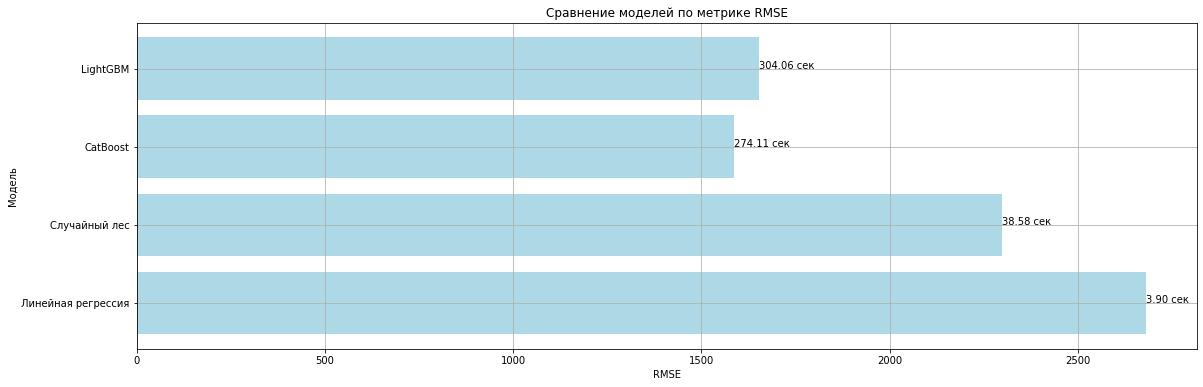

In [316]:
# Извлечение данных из DataFrame df_ml_compare
model_names = df_ml_compare['model'][1:]
metrics = df_ml_compare['rmse'][1:]
times = df_ml_compare['learning_time'][1:]

# Создание графика
plt.figure(figsize=(19, 6))
plt.barh(model_names, metrics, color='lightblue')  # Изменение цвета на более мягкий (lightblue)
plt.xlabel('RMSE')
plt.ylabel('Модель')
plt.title('Сравнение моделей по метрике RMSE')
plt.grid(True)

# Отображение времени обучения над каждым столбцом
for i, v in enumerate(metrics):
    plt.text(v + 0.01, i, f'{times.iloc[i]:.2f} сек', color='black')  # Добавление подписи "сек"

# Отображение графика
plt.show()

В ходе эксперимента были применены различные модели для предсказания значения. Результаты показали, что линейная регрессия достигла значения метрики около 2682, в то время как случайный лес показал результат около 2300. Обе модели градиентного бустинга продемонстрировали более высокую точность, с метриками около 1587-1652. Все эти модели существенно превосходят предсказания dummy-моделей, которые составляли около 4500.

Особенно выделяются модели градиентного бустинга, которые показали значительно лучшие результаты по сравнению с линейной регрессией и случайным лесом. Качество моделей градиентного бустинга превосходит dummy-модель практически в 3 раза и на 25% превышает результаты случайного леса.

Относительно времени обучения моделей, можно сказать, что время обучения градиентного бустинга LGBMRegressor незначительно превышает время обучения линейной регрессии. Однако, время обучения модели CatBoost относительно LightGBM значительно выше, на порядок.

В целом, модели градиентного бустинга показали сильное улучшение по сравнению с базовыми моделями и достаточно хорошее соотношение между качеством предсказания и временем обучения.

Однако CatBoost все же предпочтительнее учитывая меньшее время обучения и лучшие результаты метрики RMSE.

**Проведем итоговое предсказание на тестовых данных на модели CatBoost**

In [327]:
start_time = time.time()
predictions_cbr = best_model_cbr.predict(data_test[features])
end_time = time.time()

# Вычисление времени предсказания
prediction_time_cbr = end_time - start_time
# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(data_test[target], predictions_cbr))

# Вывод результатов оценки модели
print("Время предсказания: {} сек".format(round(prediction_time_cbr,2)))
print("RMSE: {}".format(round(rmse, 0)))

Время предсказания: 1.04 сек
RMSE: 1594.0


## Выводы

**Исследование моделей машинного обучения для предсказания цен автомобилей**
В рамках исследования проведено построение моделей машинного обучения с целью предсказания на основе технических характеристик цены автомобилей.

**Обработка исторических данных**
- Проведена оценка распределения значений признаков с целью выявления пропусков/аномалий в данных, которые целесообразно исключить или заменить.
- Исключены аномалии в признаках, относящихся к самим объявлениям, такие как дата создания и дата выгрузки, которые содержали большой период экспозиции и могли содержать недостоверные ценовые характеристики.
- Исключены аномальные значения года регистрации автомобилей и выбросы, которые не отражали текущее состояние рынка автомобилей.
- Выполнены замены пропусков значений в числовых и категориальных признаках.
- После обработки данных в таблице осталось порядка 330 тысяч записей.

**Разделение выборки и замена пропусков**
- Выборка разделена на обучающую и тестовую с пропорциональным разбиением по производителю.
- На основе статистики обучающей выборки выполнена замена пропусков значений мощности, типа кузова и модели автомобилей.

**Обучение моделей**
Были обучены 4 различных типа моделей:

- Линейная регрессия.
- Случайный лес.
- Градиентный бустинг CatBoost.
- Градиентный бустинг LightGBM.

**Результаты и анализ**

- Линейная регрессия показала значение метрики около 2682, случайный лес около 2300, обе модели градиентного бустинга показали метрики около 1587-1652.
- Все модели значительно улучшили предсказание по сравнению с dummy-моделями (метрика около 4500).
- Качество моделей градиентного бустинга почти в 2 раза лучше линейной регрессии и на 25% лучше случайного леса.
- Время обучения модели градиентного бустинга LGBMRegressor незначительно превышает время обучения линейной регрессии.
- Модели градиентного бустинга превосходят dummy-модель практически в 3 раза, а время обучения CatBoost значительно хуже по сравнению с LightGBM.

Модели градиентного бустинга демонстрируют отличные результаты в предсказании цен автомобилей, превосходя другие модели и сохраняя приемлемое время обучения.

Однако модель CatBoost все же оказалась предпочтительнее сочетая в себе меньшее время обучения чем у модели LightGBM и лучшие результаты метрики RMSE среди всех рассмотренных моделей.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей